# Вариационные автокодировщики

### Загрузка, нормировка и визуалиация данных

In [1]:
import torchvision.datasets

In [2]:
from torchvision.datasets import MNIST#, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import math
#dtype = torch.cuda.FloatTensor
import chainer

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 30, 30)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy())
        plt.axis('off')

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(20, 20 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 30, 30)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy())
        plt.axis('off')

In [5]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
#data = pkl.load(open('test_data','rb'))
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

In [6]:
import numpy as np
data = np.load('/home/sayankotor/data/calo_gan_data/electrons_1_100_1D__v2_50K.npz')
data_img = (data['EnergyDeposit'])
data_img.shape

(50000, 30, 30)

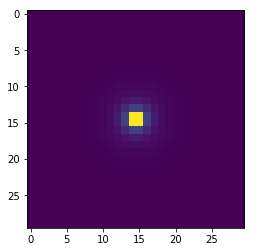

In [7]:
plt.imshow(data_img.mean(0))
plt.show()

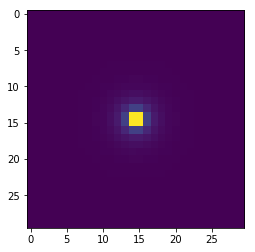

In [8]:
plt.imshow(data_img.std(0))
plt.show()

In [9]:
n_data_img = []

min_ = np.min(data_img)
max_ = np.max(data_img)

for i, elem in enumerate(data_img):
    if (i%5000 == 0):
        print (i)
    n_elem = elem /(max_ - min_)
    n_data_img.append(n_elem)
n_data_img = np.array(n_data_img)


n_data_img_1 = []
print(type(n_data_img_1))

mean = n_data_img.mean(0)
std = n_data_img.std(0)

#for i, elem in enumerate(n_data_img):
    #if (i%5000 == 0):
        #print (i)
    #n_elem = (elem - mean)
    #n_elem = np.true_divide(n_elem, std)
    #n_data_img_1.append(n_elem)
#n_data_img_1 = np.array(n_data_img_1)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
<class 'list'>


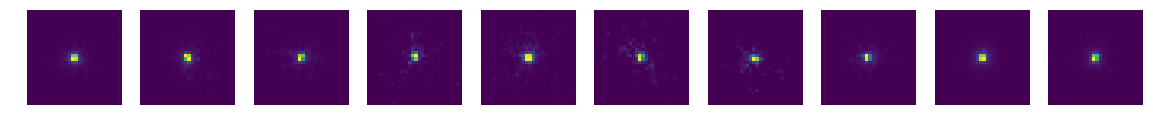

In [10]:
show_images(Variable(torch.from_numpy(n_data_img[20:30])))

In [11]:
min_ = np.min(n_data_img+1e-8)
max_ = np.max(n_data_img)
print(min_, max_)

1e-08 1.0


In [12]:
#n_data_img = np.log(n_data_img)

In [13]:
min_ = np.mean(n_data_img)
max_ = np.std(n_data_img)
print(min_, max_)

0.00187287233737 0.0182712107091


## loss function ##

In [14]:
np.std(n_data_img)

0.018271210709116224

In [15]:
import chainer

In [16]:

def reconstruction_loss_gauss_chain(x_true_object, mu_generative_distr, sigma_generative_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    answ = chainer.functions.gaussian_nll(x_true_object.data.numpy(), mu_generative_distr.data.numpy(), sigma_generative_distr.data.numpy())
    return answ


def reconstruction_loss_gauss(x_true_object, mu_generative_distr, sigma_var):
    print("mu_generative_distr.shape", mu_generative_distr.shape)
    #print ("log sigma_var ", log_sigma_var)
    #print ("sigma ", sigma)
    #print ("log sigma_var ", log_sigma_var)
    #print ("torch min ", torch.min(sigma))
    #print ("torch max ", torch.max(sigma))
    log_sigma = torch.log(sigma_var)
    print ("log_sigma ", log_sigma.sum())
    x_diff = x_true_object - mu_generative_distr
    x_power = (x_diff * x_diff) * -0.5/ sigma_var 
    print ("x_diff, x_power ", x_diff.mean(), x_power.mean() )
    #print ("x_power ", x_power.sum())
    loss = (log_sigma + math.log(2 * math.pi)) / 2 - x_power
    return torch.sum(loss, 1)


In [17]:
def kl1(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    mu_q = mu_q.float()
    mu_p = mu_p.float()
    sigma_q = sigma_q.float()
    sigma_p = sigma_p.float()
    #без этого нет стабильности и лосс улетает в нан
    sigma_q_log = torch.log(torch.clamp(sigma_q, 1-1e8, 1e-8))
    sigma_p_log = torch.log(torch.clamp(sigma_p, 1-1e8, 1e-8))

    d = mu_q.shape[1]
    res = - float(d) + sigma_p_log.sum(dim = 1) - sigma_q_log.sum(dim = 1)
    res += (sigma_q/ sigma_p).sum(dim =1)
    res += torch.sum((mu_p - mu_q) * (mu_p - mu_q) / sigma_p, dim =1)
    return 0.5 * res
    

In [18]:
def kl(q_distr, p_distr):
    m1, s1 = q_distr
    m2, s2 = p_distr
    n = m1.shape[0]
    assert(m2.shape[0] == n)
    s1 = (torch.clamp(s1, 1-1e8, 1e-8))
    s2 = (torch.clamp(s2, 1-1e8, 1e-8))
    kldiv = (torch.log(s2) - torch.log(s1) + 0.5 * ((s1**2 + (m1 - m2)**2) / (s2**2) - 1)).sum(1)
    assert(len(kldiv.shape) == 1 and kldiv.shape[0] == n)
    #print ("kldiv", kldiv.mean())
    return kldiv

## model

In [29]:
from torch.distributions import Normal, Bernoulli
from chainer.functions.math import exponential

class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU()
        )
        self.generative_mu_head = nn.Linear(200, self.D)
        self.generative_sigma_head = nn.Sequential(nn.Linear(200, self.D), nn.Softplus())

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        q_teta = self.proposal_network.forward(x)
        return self.proposal_mu_head(q_teta), torch.exp(self.proposal_sigma_head(q_teta))

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = Variable(torch.Tensor(n, self.d).fill_(0).float())
        sigma = Variable(torch.Tensor(n, self.d).fill_(1).float())
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
    
        mu, sigma = distr
        eps = torch.from_numpy(
            np.random.normal(0, 1, size=(K * sigma.shape[0], sigma.shape[1]))).float()
        return mu.repeat(K, 1) + sigma.repeat(K, 1) * Variable(eps, requires_grad=False)
        

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        m = Normal(torch.Tensor(self.d).fill_(0), torch.Tensor(self.d).fill_(1))
        answ = Variable(m.sample_n(num_samples))
        
        return answ
        

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        int_distr = self.generative_network(z)
        return (self.generative_mu_head(int_distr), self.generative_sigma_head(int_distr))

    def batch_loss(self, batch, K, isp = False):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        
        sample_prior - генерирует объекты z в латентном пространстве меньшей размерности
        
        generative_distr - по этим объектам порождает параметры распределения, которое будет 
        генерировать объекты в реальном пр-ве 
        
        есть параметры, есть изначальный батч
        насколько изначальный батч соответствует распределению с генерированными параметрами - 
        это и есть RECONSTRUCTION LOSS
        
        """
        batch = Variable(batch)
        q_phi = self.proposal_distr(batch)
        z = self.sample_latent(q_phi, K)
        self.q_phi = q_phi
        
        mu, sigma = self.generative_distr(z)
        sigma = torch.clamp(sigma, min = 1e-8)
        print ("sigma ", sigma)
        #m = Normal(mu, torch.exp(log_sigma)) 
        # = m.sample()
        answ1 = reconstruction_loss_gauss(batch, mu, sigma)
        print ("mu ", mu)
        answ_chain = reconstruction_loss_gauss_chain(batch, mu, sigma)
        
        mu_prior, sigma_prior = self.prior_distr(batch.shape[0])
        print ("q_phi mu ", q_phi[0][:5])
        print ("q_phi sigma ", q_phi[1][:5])
        answ2 = kl(q_phi, (mu_prior, sigma_prior))
        
        print("batch_loss: loss_chain, loss_simple, KL", answ_chain.data.mean(), answ1.data.mean() , answ2.data.mean() )
        #print ("shapes ", answ1.view(-1).shape,  answ2.shape)
        return torch.mean(answ1) + torch.mean(answ2) 


    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        mu, sigma = self.generative_distr(self.sample_prior(num_samples))   
        print ("generate_samples ", mu.shape, sigma.shape)
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ
    
    def generate_samples1(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        mu, sigma = self.generative_distr(self.sample_latent(self.q_phi, 1))
        z1 = self.sample_latent(self.q_phi, 1)
        print (z1.shape)
        print ("generate_samples1 ", mu.shape, sigma.shape)
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ

In [30]:
def sample_data_batch(bsize, data_):
    idxs = np.random.choice(np.arange(data_.shape[0]), size=bsize)
    return torch.FloatTensor(data_[idxs])

In [31]:
shapes = data_img.shape
n_data_img = n_data_img.reshape([shapes[0], shapes[1]*shapes[2]])

In [32]:
a = sample_data_batch(100, n_data_img)
print (type(a))
a.shape

<class 'torch.FloatTensor'>


torch.Size([100, 900])

In [33]:
import random

shapes = data_img.shape
#random.seed()
def train_model(model, tests=[], batch_size=100, K=1, num_epochs=1, learning_rate=1e-3):
    model.generative_network.train() 
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: K, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        print ("epoch:", _)
        #for i in range(500):
        for i, (batch, _) in enumerate(dataloader):
            #total = len(dataloader)
            total = 500
            batch = sample_data_batch(100, n_data_img)
            loss = model.batch_loss(batch, K)
            #loss = loss_[0] + loss_[1]
            #if (loss_[0].data[0] < 300.0):
                #print ("loss 0", loss_[0].data[0])
                #return {
                    #'model': model,
                    #'train_losses_list': train_losses,
                    #'test_results': test_results
                #}
            (loss).backward()
            #print (loss.shape)
            
            train_losses.append(loss.data.numpy()[0])
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

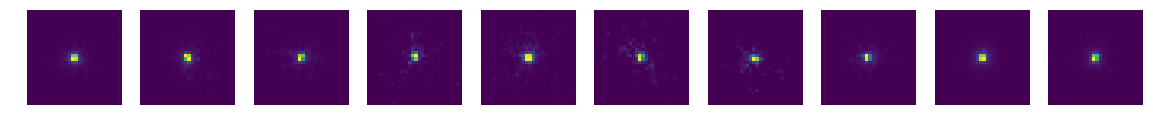

In [34]:
show_images(Variable(torch.from_numpy(n_data_img[20:30])))

In [35]:
vae_model_d2_k1 = train_model(VAE(5, 900), tests=[])

epoch: 0
sigma  Variable containing:
 0.6930  0.7039  0.7014  ...   0.6787  0.6785  0.6746
 0.6762  0.7103  0.6604  ...   0.6553  0.7327  0.6984
 0.7407  0.7006  0.7579  ...   0.6883  0.6449  0.6110
          ...             ⋱             ...          
 0.7238  0.7018  0.6729  ...   0.6117  0.6098  0.6420
 0.6736  0.6959  0.6683  ...   0.6307  0.7134  0.6690
 0.7237  0.6803  0.6764  ...   0.6644  0.6647  0.7135
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-33066.3984
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -8.6488
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -8.6524
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.1024e-03 -6.3807e-02  1.5061e-01  ...  -6.1835e-02  1.6487e-02  6.0183e-04
-6.0689e-02 -6.7476e-02  1.5889e-01  ...  -2.6700e-02  1.8030e-02  3.5030e-02
 1.9509e-02 -1.6926e-01  1.2787e-01  ...  -1.1865e-02 -2.9556e-02  1.9451e-0

sigma  Variable containing:
 0.5464  0.5906  0.5088  ...   0.5247  0.5539  0.4707
 0.4670  0.6131  0.4702  ...   0.4119  0.5797  0.4376
 0.5127  0.6084  0.5013  ...   0.5141  0.5858  0.5042
          ...             ⋱             ...          
 0.4784  0.6175  0.4721  ...   0.5238  0.5831  0.4392
 0.5128  0.5991  0.5387  ...   0.4386  0.4973  0.3630
 0.4666  0.6262  0.4974  ...   0.4791  0.5799  0.4540
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-62180.0352
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  3.5514
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-03 *
 -7.9295
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9654e-02  9.8761e-02 -4.4696e-02  ...  -7.8735e-03  8.2447e-03 -2.9137e-02
 4.1677e-03  1.4329e-01  7.2217e-02  ...  -2.6108e-02  7.9474e-02  1.1138e-01
 3.5990e-03  7.5732e-02  1.9205e-02  ...   9.0652e-03  2.9700e-02  5.4739e-02
       

sigma  Variable containing:
 0.2088  0.3676  0.2806  ...   0.2618  0.2908  0.1852
 0.1159  0.2919  0.1652  ...   0.1831  0.2603  0.1342
 0.0911  0.2911  0.1636  ...   0.1521  0.2594  0.1219
          ...             ⋱             ...          
 0.2599  0.4035  0.2958  ...   0.3151  0.3925  0.2719
 0.2436  0.3853  0.2915  ...   0.3098  0.3299  0.2474
 0.1612  0.3389  0.2333  ...   0.2199  0.2692  0.1785
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -1.1684
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0096
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -1.2315
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5147e-03 -8.6625e-02 -1.2817e-01  ...   1.0777e-01 -1.9334e-02 -1.8024e-02
-2.3158e-03 -9.4004e-02 -1.7431e-01  ...   3.1932e-02 -1.0633e-01 -8.9400e-02
-5.5032e-02 -1.6154e-01 -1.3986e-01  ...   6.4448e-02 -1.0802e-01  2.7991e

q_phi mu  Variable containing:
1.00000e-02 *
  0.0878  0.0989  0.5088  0.1375  0.6878
  0.0848  0.0927  0.5093  0.1452  0.6887
  0.0896  0.0929  0.5129  0.1396  0.7185
 -0.0496  0.0280  0.8741  0.2109  2.0306
  0.0371  0.0066  1.0704  0.2056  2.2503
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0241  1.0306  1.0983  1.0208  1.0762
 1.0240  1.0305  1.0983  1.0207  1.0762
 1.0241  1.0306  1.0984  1.0208  1.0762
 1.0261  1.0342  1.0991  1.0228  1.0794
 1.0266  1.0364  1.1010  1.0239  1.0808
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 88172.8 -187.3592460370064 1110571286528.0
sigma  Variable containing:
 0.0769  0.1518  0.1016  ...   0.0864  0.1420  0.0702
 0.1466  0.2420  0.1839  ...   0.1668  0.2281  0.1398
 0.0495  0.1168  0.0817  ...   0.0536  0.1081  0.0398
          ...             ⋱             ...          
 0.0320  0.1069  0.0591  ...   0.0447  0.0988  0.0323
 0.0324  0.1030  0.0541  ...   0.0524  0.0904  0.0369
 0.0100  0.0534

sigma  Variable containing:
 0.0050  0.0176  0.0066  ...   0.0090  0.0097  0.0038
 0.0226  0.0454  0.0256  ...   0.0303  0.0370  0.0206
 0.0232  0.0535  0.0285  ...   0.0257  0.0293  0.0158
          ...             ⋱             ...          
 0.0039  0.0110  0.0057  ...   0.0043  0.0077  0.0023
 0.1052  0.1561  0.1088  ...   0.1147  0.1183  0.0874
 0.0070  0.0121  0.0079  ...   0.0062  0.0093  0.0034
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.4988
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.9013
[torch.FloatTensor of size 1]
 Variable containing:
-0.3988
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2689e-01 -1.1696e-02  1.3145e-02  ...  -9.4474e-02  2.8522e-03  8.0266e-02
-2.3612e-02  8.7730e-02  1.7148e-03  ...  -8.4609e-02  4.6306e-03  1.9762e-02
-7.2876e-02  8.1354e-02  1.3434e-01  ...  -6.2961e-02  7.5705e-02  1.1584e-01
           

q_phi mu  Variable containing:
1.00000e-03 *
  1.4304 -0.8048 -0.6569  2.0360 -9.4674
 -0.2946  0.2515 -1.7811 -0.6074 -3.1200
 -0.3204  0.6519 -2.1984 -0.8785 -3.8938
 -0.1872 -0.6973 -1.2012  0.1650 -0.7828
 -0.3709  0.6051 -2.0807 -0.7625 -3.6537
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 1.0286  1.0458  1.0974  1.0185  1.1030
 1.0251  1.0449  1.0981  1.0231  1.0941
 1.0250  1.0446  1.0982  1.0231  1.0941
 1.0269  1.0451  1.0971  1.0230  1.0969
 1.0250  1.0447  1.0982  1.0229  1.0940
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 84318.7 -513.9068882751465 95521572014.08
sigma  Variable containing:
 0.0472  0.0405  0.0398  ...   0.0447  0.0485  0.0469
 0.0140  0.0097  0.0105  ...   0.0095  0.0083  0.0073
 0.0159  0.0111  0.0127  ...   0.0108  0.0095  0.0090
          ...             ⋱             ...          
 0.0602  0.0494  0.0503  ...   0.0466  0.0516  0.0477
 0.0204  0.0189  0.0173  ...   0.0218  0.0198  0.0184
 0.0248  0.0146 

batch_loss: loss_chain, loss_simple, KL 84662.0 -538.7713975524903 230768025681.92
sigma  Variable containing:
 0.0898  0.0625  0.0592  ...   0.0701  0.0685  0.0747
 0.0516  0.0398  0.0336  ...   0.0426  0.0427  0.0482
 0.0311  0.0172  0.0167  ...   0.0217  0.0198  0.0227
          ...             ⋱             ...          
 0.0696  0.0452  0.0429  ...   0.0551  0.0528  0.0604
 0.0700  0.0546  0.0464  ...   0.0590  0.0608  0.0666
 0.0057  0.0030  0.0027  ...   0.0036  0.0042  0.0045
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.1877
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.6207
[torch.FloatTensor of size 1]
 Variable containing:
-0.2164
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.8543e-02 -2.2423e-02  8.9547e-03  ...  -3.5220e-02 -6.7856e-03 -5.6054e-03
-5.8634e-02  3.5023e-02  5.4990e-02  ...  -4.8459e-02 -1.7587e-02  1.0082e-02
 1.733

q_phi mu  Variable containing:
1.00000e-03 *
 -0.0662 -0.7889 -0.5217 -0.3546  1.3136
  1.0342  0.2965 -1.2556 -0.8848 -2.2577
  0.0421 -0.7596 -0.4704 -0.3191  1.3905
 -0.1259 -0.8143 -0.2733  0.1467  1.0426
 -0.0557 -0.9138 -0.3295 -0.1410  1.4668
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.9993  1.0223  1.0641  0.9957  1.0646
 1.0019  1.0227  1.0637  0.9935  1.0690
 0.9997  1.0225  1.0639  0.9956  1.0649
 0.9989  1.0226  1.0640  0.9959  1.0637
 0.9996  1.0222  1.0638  0.9957  1.0646
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 85134.8 -578.9824696683884 27617687639.04
sigma  Variable containing:
 0.0598  0.0338  0.0231  ...   0.0293  0.0367  0.0464
 0.0253  0.0165  0.0083  ...   0.0147  0.0140  0.0209
 0.1097  0.0741  0.0512  ...   0.0704  0.0921  0.1018
          ...             ⋱             ...          
 0.0566  0.0362  0.0215  ...   0.0363  0.0441  0.0551
 0.0527  0.0262  0.0188  ...   0.0251  0.0305  0.0353
 0.0659  0.0414 

sigma  Variable containing:
 0.0352  0.0204  0.0072  ...   0.0158  0.0211  0.0260
 0.0879  0.0523  0.0277  ...   0.0403  0.0629  0.0729
 0.0901  0.0518  0.0268  ...   0.0443  0.0532  0.0742
          ...             ⋱             ...          
 0.0108  0.0055  0.0016  ...   0.0042  0.0072  0.0112
 0.0068  0.0038  0.0008  ...   0.0025  0.0040  0.0054
 0.0299  0.0179  0.0061  ...   0.0126  0.0200  0.0259
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.2628
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -2.3572
[torch.FloatTensor of size 1]
 Variable containing:
-0.1618
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.5913e-02 -2.4478e-02  3.7008e-03  ...   1.5394e-02 -9.8267e-02  1.9122e-02
-1.3768e-02  1.4279e-03  1.0979e-02  ...  -2.7733e-02  1.2068e-02  1.3505e-02
-3.2150e-02  5.5811e-02  3.1468e-02  ...   5.7788e-02 -2.8081e-02 -1.4477e-02
           

sigma  Variable containing:
 0.1015  0.0496  0.0226  ...   0.0382  0.0558  0.0806
 0.0225  0.0104  0.0026  ...   0.0052  0.0134  0.0172
 0.0733  0.0388  0.0164  ...   0.0324  0.0447  0.0692
          ...             ⋱             ...          
 0.0193  0.0069  0.0020  ...   0.0038  0.0091  0.0130
 0.0442  0.0184  0.0060  ...   0.0126  0.0210  0.0322
 0.0638  0.0314  0.0125  ...   0.0229  0.0387  0.0518
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.3917
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -2.0678
[torch.FloatTensor of size 1]
 Variable containing:
-0.1345
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.2006e-02  4.8355e-02  1.4184e-02  ...   9.0314e-03 -4.8204e-02  3.8467e-02
-6.1643e-03  1.0511e-01  8.1434e-02  ...  -4.9809e-03 -4.4090e-02  3.9062e-02
-2.7903e-02  1.1351e-01  1.0750e-02  ...   2.1834e-02 -3.9667e-02  9.0587e-02
           

sigma  Variable containing:
 0.0113  0.0039  0.0011  ...   0.0020  0.0047  0.0078
 0.0225  0.0075  0.0026  ...   0.0042  0.0087  0.0127
 0.0346  0.0130  0.0050  ...   0.0095  0.0153  0.0269
          ...             ⋱             ...          
 0.0737  0.0383  0.0184  ...   0.0315  0.0453  0.0693
 0.0345  0.0161  0.0062  ...   0.0102  0.0184  0.0276
 0.0546  0.0234  0.0104  ...   0.0174  0.0270  0.0434
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.7636
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.2779
[torch.FloatTensor of size 1]
 Variable containing:
-0.2235
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9134e-02 -1.0967e-02 -9.2698e-03  ...   1.1378e-01  7.0034e-02  6.0242e-02
 8.7270e-02 -3.8395e-02  1.9177e-04  ...   4.5347e-02  2.2734e-02 -2.3685e-03
-1.6497e-02  5.1265e-02 -2.0808e-02  ...   2.1227e-02  3.5458e-02  2.7252e-02
           

sigma  Variable containing:
 0.0306  0.0142  0.0080  ...   0.0153  0.0144  0.0248
 0.0158  0.0061  0.0033  ...   0.0071  0.0062  0.0137
 0.0097  0.0036  0.0016  ...   0.0039  0.0036  0.0064
          ...             ⋱             ...          
 0.0338  0.0163  0.0089  ...   0.0149  0.0142  0.0247
 0.0124  0.0048  0.0025  ...   0.0048  0.0050  0.0103
 0.0193  0.0071  0.0038  ...   0.0084  0.0082  0.0143
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0099
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.7257
[torch.FloatTensor of size 1]
 Variable containing:
-0.2574
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6850e-02 -1.0923e-02 -6.5172e-03  ...  -3.3410e-02  2.7094e-03  2.8648e-02
-2.3332e-02  8.7788e-02 -3.6652e-02  ...  -1.0287e-02  2.4919e-02  5.2657e-02
 5.7700e-03  8.6400e-03  2.5163e-02  ...   2.2845e-03 -7.9726e-02 -2.4149e-02
           

sigma  Variable containing:
 0.0349  0.0149  0.0160  ...   0.0239  0.0129  0.0221
 0.0441  0.0212  0.0220  ...   0.0353  0.0201  0.0336
 0.0097  0.0028  0.0033  ...   0.0060  0.0025  0.0056
          ...             ⋱             ...          
 0.0242  0.0107  0.0113  ...   0.0225  0.0094  0.0189
 0.0106  0.0035  0.0040  ...   0.0076  0.0034  0.0066
 0.0066  0.0021  0.0022  ...   0.0047  0.0015  0.0038
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3738
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.9808
[torch.FloatTensor of size 1]
 Variable containing:
-0.5952
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.4921e-02  2.0673e-02 -1.2325e-03  ...  -6.7650e-03  1.5627e-02  1.7163e-02
-2.0369e-03  7.1152e-02 -3.1066e-02  ...   5.0033e-02  2.6595e-02  5.6783e-02
-3.6074e-02  2.2189e-02 -7.6945e-02  ...   3.7579e-03  3.6790e-02  5.4287e-02
           

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.1298
[torch.FloatTensor of size 1]
 Variable containing:
-0.2566
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.9810e-02  6.7676e-02  5.7305e-02  ...  -2.0861e-02  7.3766e-02  7.4039e-02
 1.1267e-02  4.1993e-02  4.7532e-02  ...  -1.9920e-02  7.4473e-02  6.8091e-02
 7.6793e-03  7.0464e-02  3.8510e-03  ...   1.6435e-02  1.6839e-02  6.0528e-02
                ...                   ⋱                   ...                
 2.3754e-02  4.6469e-02  6.1430e-02  ...  -1.9865e-02  7.5400e-03  7.6143e-02
 4.2630e-02  8.2194e-02  9.0853e-02  ...   6.1759e-03  1.0119e-01  5.6167e-02
 2.1468e-02  5.0145e-02  2.9919e-02  ...  -8.1103e-02  3.1979e-02  6.1411e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-03 *
 -0.0913  0.2866 -0.0230 -0.2718 -0.1330
 -0.0376 -0.0548  0.5765  0.0671  1.0196
 -0.1883  0.3158 -0.1109 -0.2260 -0.0518
 -0.1880 -0.1568  0.8960  0.2445  2.2683
 -0.6987 -0.0548  0.9650  0.095

Train loss: 8.26879e+09 Batch 70 of 500           sigma  Variable containing:
 0.0153  0.0135  0.0244  ...   0.0333  0.0149  0.0153
 0.0139  0.0112  0.0201  ...   0.0285  0.0137  0.0119
 0.0176  0.0154  0.0266  ...   0.0350  0.0160  0.0157
          ...             ⋱             ...          
 0.0122  0.0104  0.0202  ...   0.0258  0.0109  0.0104
 0.0172  0.0137  0.0238  ...   0.0300  0.0134  0.0135
 0.0091  0.0089  0.0162  ...   0.0216  0.0097  0.0093
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9409
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.1804
[torch.FloatTensor of size 1]
 Variable containing:
-0.2389
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7213e-02  4.7559e-02 -1.2678e-02  ...   8.1004e-02  4.6125e-02  2.4776e-02
 3.9902e-02  1.2767e-03 -4.5620e-02  ...   5.3451e-02 -1.7926e-02 -6.7056e-02
 2.6041e-02 -4.3327e-03 -1.2432e-02  ..

sigma  Variable containing:
 0.0126  0.0116  0.0274  ...   0.0267  0.0172  0.0141
 0.0028  0.0029  0.0084  ...   0.0076  0.0048  0.0031
 0.0325  0.0325  0.0618  ...   0.0615  0.0390  0.0367
          ...             ⋱             ...          
 0.0210  0.0218  0.0435  ...   0.0411  0.0252  0.0233
 0.0132  0.0135  0.0290  ...   0.0280  0.0191  0.0152
 0.0202  0.0211  0.0423  ...   0.0427  0.0274  0.0238
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.7555
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.0070
[torch.FloatTensor of size 1]
 Variable containing:
-0.1016
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.1913e-03  4.1882e-02  3.0507e-02  ...  -1.6095e-02  6.2208e-02  4.5572e-02
-9.5268e-02 -6.5622e-03 -3.9935e-02  ...   2.3518e-02  3.9015e-02  1.3091e-01
-3.4488e-03  4.8560e-02  2.8517e-02  ...  -4.6945e-03  7.8547e-02  9.6272e-02
           

Train loss: 7.35573e+09 Batch 80 of 500           sigma  Variable containing:
 0.0091  0.0085  0.0239  ...   0.0200  0.0127  0.0118
 0.0039  0.0040  0.0120  ...   0.0096  0.0071  0.0054
 0.0020  0.0015  0.0064  ...   0.0044  0.0029  0.0021
          ...             ⋱             ...          
 0.0181  0.0167  0.0385  ...   0.0328  0.0251  0.0216
 0.0007  0.0006  0.0031  ...   0.0022  0.0012  0.0010
 0.0051  0.0047  0.0151  ...   0.0112  0.0074  0.0065
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2122
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6025
[torch.FloatTensor of size 1]
 Variable containing:
-0.1609
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.5818e-02  1.5084e-02  2.2807e-02  ...  -1.3687e-02  1.1581e-03 -2.9762e-02
 1.2647e-02  2.7554e-02  3.1799e-02  ...  -4.1207e-02 -3.5025e-02 -5.1083e-02
 5.2797e-02 -2.8083e-02  2.3912e-02  ..

sigma  Variable containing:
 0.0016  0.0011  0.0051  ...   0.0032  0.0023  0.0025
 0.0053  0.0034  0.0125  ...   0.0088  0.0070  0.0082
 0.0064  0.0047  0.0154  ...   0.0120  0.0084  0.0107
          ...             ⋱             ...          
 0.0211  0.0160  0.0391  ...   0.0333  0.0265  0.0316
 0.0077  0.0059  0.0185  ...   0.0138  0.0113  0.0126
 0.0040  0.0031  0.0103  ...   0.0081  0.0061  0.0071
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5728
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.9789
[torch.FloatTensor of size 1]
 Variable containing:
-0.3876
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.5499e-02 -3.9935e-02 -2.0335e-02  ...   4.1756e-02 -3.7370e-02  1.1838e-01
 1.1343e-02  1.5585e-02 -5.9298e-02  ...   6.9957e-03  9.3203e-03  6.9211e-02
-1.6310e-02  2.6013e-02 -4.6078e-02  ...   5.5957e-02  1.7358e-02  8.2324e-02
           

Train loss: 4.3371e+09 Batch 90 of 500           sigma  Variable containing:
 0.0058  0.0049  0.0109  ...   0.0077  0.0065  0.0104
 0.0032  0.0032  0.0067  ...   0.0050  0.0045  0.0074
 0.0185  0.0164  0.0285  ...   0.0233  0.0205  0.0321
          ...             ⋱             ...          
 0.0024  0.0023  0.0052  ...   0.0039  0.0036  0.0059
 0.0040  0.0033  0.0075  ...   0.0053  0.0049  0.0081
 0.0199  0.0170  0.0293  ...   0.0242  0.0206  0.0321
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.7290
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.0182
[torch.FloatTensor of size 1]
 Variable containing:
-0.3870
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0122e-02  4.1413e-03  3.0468e-03  ...  -2.9596e-02  2.1597e-02 -6.1151e-03
-2.7154e-02  4.7624e-02 -1.1836e-02  ...  -8.3412e-03  2.2027e-02 -1.1450e-02
-1.6520e-02  5.0907e-02 -2.7685e-03  ...

sigma  Variable containing:
 0.0074  0.0064  0.0069  ...   0.0065  0.0054  0.0118
 0.0022  0.0021  0.0020  ...   0.0019  0.0016  0.0035
 0.0062  0.0052  0.0056  ...   0.0054  0.0047  0.0107
          ...             ⋱             ...          
 0.0191  0.0162  0.0173  ...   0.0173  0.0150  0.0299
 0.0061  0.0056  0.0054  ...   0.0048  0.0045  0.0088
 0.0036  0.0033  0.0034  ...   0.0030  0.0026  0.0062
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5137
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8343
[torch.FloatTensor of size 1]
 Variable containing:
-0.4419
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.8259e-02  9.1878e-03 -3.7839e-02  ...   1.3393e-02  3.8108e-02  3.7764e-02
 7.6325e-02  4.0028e-04 -2.9379e-02  ...  -2.8681e-02 -3.5354e-02  4.4603e-02
-7.5996e-03 -1.3943e-02  6.6763e-04  ...  -1.0645e-02  3.3030e-02  7.0519e-02
           

Train loss: 3.27107e+09 Batch 100 of 500           
sigma  Variable containing:
 0.0192  0.0137  0.0083  ...   0.0110  0.0084  0.0178
 0.0084  0.0064  0.0035  ...   0.0053  0.0038  0.0096
 0.0043  0.0032  0.0018  ...   0.0030  0.0019  0.0062
          ...             ⋱             ...          
 0.0346  0.0270  0.0175  ...   0.0238  0.0180  0.0362
 0.0370  0.0283  0.0189  ...   0.0253  0.0195  0.0390
 0.0082  0.0061  0.0035  ...   0.0054  0.0040  0.0105
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.0778
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8448
[torch.FloatTensor of size 1]
 Variable containing:
-0.2029
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8459e-02  3.7568e-02  3.7758e-03  ...  -2.2603e-02  6.0762e-04 -4.0771e-02
-9.0728e-03  4.1690e-03 -4.2667e-03  ...   2.5070e-02  4.1121e-03 -5.5570e-02
-1.1206e-01  1.6256e-02  6.3067e-03  

sigma  Variable containing:
 0.0219  0.0117  0.0055  ...   0.0110  0.0062  0.0161
 0.0041  0.0021  0.0006  ...   0.0019  0.0008  0.0026
 0.0165  0.0084  0.0041  ...   0.0086  0.0051  0.0145
          ...             ⋱             ...          
 0.0162  0.0087  0.0036  ...   0.0080  0.0039  0.0110
 0.0319  0.0174  0.0091  ...   0.0156  0.0098  0.0227
 0.0032  0.0014  0.0005  ...   0.0012  0.0006  0.0020
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-4.0103e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.6355
[torch.FloatTensor of size 1]
 Variable containing:
-0.1361
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.6654e-02  2.8397e-02 -1.8929e-02  ...  -2.2726e-02 -6.8756e-03  4.3825e-02
 8.2137e-02 -1.0772e-02 -7.6855e-03  ...  -7.5286e-02 -7.3117e-03  2.1492e-02
-3.3253e-02 -1.4979e-03  3.3759e-02  ...  -6.6728e-03  9.0051e-03  6.1738e-02
                ...   

Train loss: 3.03518e+09 Batch 110 of 500           sigma  Variable containing:
 0.0428  0.0176  0.0095  ...   0.0189  0.0098  0.0269
 0.0059  0.0018  0.0007  ...   0.0021  0.0009  0.0035
 0.0241  0.0099  0.0046  ...   0.0104  0.0047  0.0132
          ...             ⋱             ...          
 0.0204  0.0076  0.0039  ...   0.0098  0.0043  0.0149
 0.0271  0.0113  0.0056  ...   0.0129  0.0058  0.0173
 0.0203  0.0068  0.0033  ...   0.0081  0.0036  0.0125
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3764
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.8150
[torch.FloatTensor of size 1]
 Variable containing:
-0.1767
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.4272e-02  2.8086e-02 -5.2464e-02  ...   2.9743e-02  7.3845e-03  7.1247e-02
-5.5176e-03  1.6633e-02 -9.3351e-04  ...   4.7818e-02 -3.8440e-02 -1.4417e-03
 1.0469e-01  3.0655e-02 -4.5277e-02  .

mu  Variable containing:
 1.8523e-02  1.9503e-02 -2.0438e-02  ...  -5.6304e-02  1.1943e-02  6.0924e-03
-4.3305e-02  8.2743e-04 -4.9976e-02  ...  -1.2717e-02  2.3022e-02  3.1004e-02
-1.9634e-02  5.5787e-04 -2.6005e-02  ...  -5.4452e-02 -6.4969e-04  5.9482e-03
                ...                   ⋱                   ...                
 5.3514e-02 -7.1116e-03 -4.1277e-02  ...  -4.3823e-02  1.7414e-02  3.7037e-02
 5.6673e-02  1.1344e-02 -5.1078e-02  ...  -3.7818e-02 -6.1308e-03  2.5693e-02
 6.3808e-02 -4.0357e-03 -4.4397e-02  ...  -4.2069e-02 -1.7198e-03  8.6643e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -1.5081  1.5173  1.9340  3.8326  4.8221
  0.4321 -0.8613  1.2868  1.4489  1.7946
  3.0375 -1.9411  1.3136 -0.8811 -3.1845
  1.1344 -2.2982 -2.1144 -0.7828 -5.4856
 -1.5583 -1.0098  4.4357  1.2359  6.0447
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8925  0.9501  0.9329  0.8784  0.9535
 0.8915  0.9497  0.9329  0.8775  0.

sigma  Variable containing:
1.00000e-02 *
 2.2993  0.5773  0.4065  ...   0.8124  0.3600  1.0536
 2.2213  0.5717  0.4280  ...   0.8448  0.3987  1.1994
 0.8026  0.1378  0.0951  ...   0.2240  0.0867  0.3373
          ...             ⋱             ...          
 0.2775  0.0374  0.0236  ...   0.0683  0.0225  0.1103
 1.6520  0.3851  0.2638  ...   0.5872  0.2445  0.8354
 0.2150  0.0261  0.0143  ...   0.0525  0.0144  0.0745
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.1386
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.9960
[torch.FloatTensor of size 1]
 Variable containing:
-0.5850
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.6581e-02 -1.0852e-02 -4.8963e-02  ...  -3.2227e-02  4.1254e-02  2.4265e-02
-9.3019e-03  9.9694e-03 -9.6526e-03  ...  -7.0872e-03  5.5774e-02  5.6935e-02
 4.9543e-03 -5.3131e-02 -9.1528e-03  ...  -1.7540e-03  5.2208e-02  2.2780e-

sigma  Variable containing:
 0.0140  0.0054  0.0042  ...   0.0068  0.0043  0.0090
 0.0160  0.0073  0.0054  ...   0.0096  0.0057  0.0122
 0.0150  0.0064  0.0046  ...   0.0082  0.0046  0.0105
          ...             ⋱             ...          
 0.0320  0.0157  0.0129  ...   0.0192  0.0127  0.0252
 0.0178  0.0079  0.0064  ...   0.0104  0.0069  0.0137
 0.0231  0.0107  0.0079  ...   0.0127  0.0080  0.0154
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2192
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -5.5055
[torch.FloatTensor of size 1]
 Variable containing:
-1.4997
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5942e-02  8.0848e-02 -2.4811e-01  ...   5.4514e-03  2.7163e-01  8.0542e-02
-4.2166e-02  7.6999e-02 -2.5405e-01  ...   3.8960e-02  3.0704e-01  8.8564e-02
-5.3852e-02  7.6808e-02 -2.7303e-01  ...   5.1398e-02  3.0503e-01  9.8273e-02
           

sigma  Variable containing:
 0.0277  0.0278  0.0225  ...   0.0268  0.0251  0.0340
 0.0427  0.0351  0.0315  ...   0.0321  0.0312  0.0432
 0.0336  0.0310  0.0264  ...   0.0314  0.0253  0.0356
          ...             ⋱             ...          
 0.0553  0.0501  0.0401  ...   0.0486  0.0435  0.0604
 0.0355  0.0344  0.0302  ...   0.0322  0.0309  0.0382
 0.0523  0.0455  0.0414  ...   0.0493  0.0406  0.0576
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.9110
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -7.5567
[torch.FloatTensor of size 1]
 Variable containing:
-0.1705
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6372e-02  8.1975e-02 -2.1764e-01  ...  -1.0615e-01  2.8972e-01 -5.3313e-02
 2.3286e-02  1.2742e-01 -2.6770e-01  ...  -7.7134e-02  3.0000e-01 -4.7794e-02
 3.1152e-02  8.0790e-02 -1.2335e-01  ...  -8.9493e-02  2.2268e-01 -9.3692e-02
           

sigma  Variable containing:
 0.0900  0.0960  0.0887  ...   0.0863  0.0951  0.1045
 0.0534  0.0687  0.0652  ...   0.0618  0.0616  0.0669
 0.0927  0.1053  0.1016  ...   0.0996  0.1064  0.1152
          ...             ⋱             ...          
 0.0735  0.0928  0.0887  ...   0.0810  0.0964  0.0968
 0.0606  0.0716  0.0557  ...   0.0565  0.0621  0.0732
 0.0696  0.0769  0.0719  ...   0.0661  0.0776  0.0809
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.2894
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -6.8993
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -6.4850
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.6307e-02  1.0188e-01 -1.1701e-01  ...  -1.1486e-01  1.2430e-01 -8.0241e-02
 6.1302e-02  1.0613e-01 -7.7125e-02  ...  -1.1085e-01  8.3626e-02 -1.4100e-01
-5.1502e-03  1.0728e-01 -7.6655e-02  ...  -6.7039e-02  1.3912e-01 -8.1117e

sigma  Variable containing:
 0.1096  0.1258  0.1354  ...   0.1100  0.1373  0.1332
 0.1024  0.1227  0.1279  ...   0.1132  0.1329  0.1314
 0.0967  0.1177  0.1239  ...   0.1070  0.1290  0.1256
          ...             ⋱             ...          
 0.1004  0.1252  0.1187  ...   0.1051  0.1255  0.1220
 0.1082  0.1291  0.1374  ...   0.1219  0.1427  0.1420
 0.1089  0.1206  0.1302  ...   0.1012  0.1274  0.1344
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.0577
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -5.9360
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -4.7564
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.9247e-02  1.0227e-01 -4.4642e-02  ...  -7.7785e-02  7.9584e-02 -8.9672e-02
 2.0066e-02  8.7170e-02 -8.2043e-02  ...  -8.6932e-02  1.2333e-01 -8.2928e-02
 1.5149e-02  8.2944e-02 -8.2350e-02  ...  -9.6880e-02  1.3019e-01 -8.3051e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.0356  0.5756  0.4368  2.4951  4.6891
  0.4814 -1.6648  1.8732  2.1083  1.7279
 -0.1534  0.1360 -2.8205 -1.0800 -5.4563
 -2.7849  4.1818  0.7134  2.6369  2.6947
  0.4697 -1.1938 -2.7629 -1.2612 -5.4844
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8178  0.8795  0.8655  0.8131  0.8979
 0.8168  0.8789  0.8654  0.8125  0.8965
 0.8158  0.8780  0.8653  0.8120  0.8956
 0.8189  0.8801  0.8660  0.8144  0.8994
 0.8158  0.8778  0.8651  0.8119  0.8955
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 88285.6 -157.48609577178956 1517896734.64
sigma  Variable containing:
 0.0807  0.1103  0.1218  ...   0.0889  0.1337  0.1175
 0.0830  0.1187  0.1317  ...   0.0993  0.1336  0.1195
 0.0860  0.1151  0.1356  ...   0.1001  0.1308  0.1176
          ...             ⋱             ...          
 0.0631  0.0961  0.1032  ...   0.0741  0.1135  0.0964
 0.0560  0.0930  0.0991  ...   0.0724  0.1059  0.0831
 0.0705  0.0972 

sigma  Variable containing:
 0.0753  0.1068  0.1322  ...   0.0878  0.1262  0.1025
 0.0922  0.1126  0.1409  ...   0.0901  0.1450  0.1241
 0.0625  0.0936  0.1126  ...   0.0728  0.1210  0.0940
          ...             ⋱             ...          
 0.0740  0.1036  0.1266  ...   0.0839  0.1257  0.1013
 0.0926  0.1230  0.1324  ...   0.0920  0.1409  0.1261
 0.0861  0.1282  0.1319  ...   0.0974  0.1436  0.1163
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.1280
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -5.3071
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -4.8595
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.4498e-02  8.0440e-02 -6.8855e-02  ...  -9.5379e-02  6.3472e-02 -1.3370e-01
 2.7164e-02  8.2023e-02 -2.0261e-01  ...  -8.5963e-02  2.2104e-01 -7.7895e-02
-2.0127e-03  3.8182e-02 -1.5628e-01  ...  -1.1504e-01  1.7704e-01 -9.9784e

sigma  Variable containing:
 0.0976  0.1171  0.1513  ...   0.0890  0.1514  0.1226
 0.0737  0.1008  0.1173  ...   0.0754  0.1332  0.1067
 0.0376  0.0636  0.0903  ...   0.0451  0.0908  0.0583
          ...             ⋱             ...          
 0.0848  0.1141  0.1555  ...   0.0902  0.1582  0.1160
 0.0568  0.0821  0.1144  ...   0.0643  0.1207  0.0889
 0.0715  0.0974  0.1333  ...   0.0775  0.1406  0.1102
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.3188
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -4.0536
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -6.5550
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.5892e-02  8.8187e-02 -1.6519e-01  ...  -3.3504e-02  1.7199e-01 -6.5602e-02
 3.0187e-02  3.4532e-02 -2.8564e-01  ...  -6.1369e-02  2.9627e-01 -9.7949e-04
 7.8061e-02  8.2911e-02 -4.1919e-03  ...  -1.4832e-01  4.4374e-02 -1.3113e

q_phi mu  Variable containing:
1.00000e-04 *
 -0.1129 -0.0651 -2.6551 -1.8345 -4.0950
  0.5978 -0.0358  0.6530  0.2663  1.8178
 -0.6853  1.6269  0.3442  1.0265  2.7099
 -0.8304  2.1950  2.2820  0.6316  5.5306
  0.2792 -0.4652 -0.5647 -0.8608 -0.7893
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8107  0.8727  0.8606  0.8077  0.8913
 0.8119  0.8737  0.8607  0.8082  0.8925
 0.8136  0.8746  0.8612  0.8097  0.8950
 0.8152  0.8754  0.8615  0.8106  0.8965
 0.8112  0.8732  0.8607  0.8079  0.8918
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 86773.0 -351.6081231689453 1073708262.16
sigma  Variable containing:
 0.0430  0.0706  0.1038  ...   0.0544  0.1154  0.0670
 0.0334  0.0527  0.0926  ...   0.0369  0.0948  0.0499
 0.0633  0.0862  0.1309  ...   0.0674  0.1331  0.0993
          ...             ⋱             ...          
 0.0407  0.0609  0.0981  ...   0.0460  0.1052  0.0663
 0.0392  0.0618  0.1085  ...   0.0433  0.1088  0.0600
 0.0749  0.0989  

sigma  Variable containing:
 0.0386  0.0562  0.0958  ...   0.0412  0.1079  0.0636
 0.0435  0.0604  0.1017  ...   0.0431  0.1046  0.0604
 0.0305  0.0487  0.0896  ...   0.0385  0.0938  0.0515
          ...             ⋱             ...          
 0.0228  0.0372  0.0792  ...   0.0286  0.0794  0.0422
 0.0338  0.0520  0.0898  ...   0.0373  0.1002  0.0567
 0.0539  0.0687  0.1241  ...   0.0560  0.1184  0.0773
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -2.7040
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -2.8837
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -8.3152
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.1507e-02  6.1865e-02 -1.6073e-01  ...  -9.4135e-02  2.1168e-01 -8.4649e-02
 2.8851e-02  9.8435e-02 -8.2948e-02  ...  -6.6059e-02  8.8773e-02 -1.1661e-01
 1.0482e-02  7.3716e-02 -9.2645e-02  ...  -8.8559e-02  1.2713e-01 -1.1387e

sigma  Variable containing:
 0.0234  0.0373  0.0878  ...   0.0292  0.0871  0.0430
 0.0097  0.0186  0.0507  ...   0.0124  0.0476  0.0180
 0.0190  0.0321  0.0725  ...   0.0239  0.0760  0.0352
          ...             ⋱             ...          
 0.0216  0.0320  0.0774  ...   0.0237  0.0764  0.0362
 0.0322  0.0469  0.0989  ...   0.0361  0.0994  0.0557
 0.0269  0.0371  0.0856  ...   0.0273  0.0843  0.0416
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.0914
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.9294
[torch.FloatTensor of size 1]
 Variable containing:
-0.1592
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7880e-02  6.2798e-02 -1.1314e-01  ...  -6.6876e-02  1.7164e-01 -8.1841e-02
 7.9382e-02  5.7640e-02 -1.0996e-01  ...  -1.1053e-01  6.3381e-02 -1.2409e-01
 1.6236e-02  3.6939e-02 -1.4239e-01  ...  -9.7801e-02  2.1244e-01 -9.9850e-02
           

sigma  Variable containing:
 0.0136  0.0204  0.0630  ...   0.0156  0.0649  0.0232
 0.0153  0.0250  0.0687  ...   0.0181  0.0740  0.0294
 0.0149  0.0222  0.0682  ...   0.0168  0.0718  0.0287
          ...             ⋱             ...          
 0.0365  0.0431  0.1031  ...   0.0326  0.1025  0.0532
 0.0211  0.0299  0.0750  ...   0.0224  0.0839  0.0377
 0.0272  0.0344  0.0909  ...   0.0264  0.0919  0.0440
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.4056
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -7.1128
[torch.FloatTensor of size 1]
 Variable containing:
-0.1823
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8163e-02  7.7209e-03 -1.6024e-01  ...  -5.0726e-02  1.0875e-01 -4.5505e-02
-5.6054e-02 -1.3637e-02 -2.3158e-01  ...  -7.7905e-03  2.2684e-01 -3.0861e-02
-2.7212e-02  1.7142e-02 -2.1114e-01  ...  -3.8370e-02  2.3665e-01 -6.3460e-02
           

sigma  Variable containing:
 0.0195  0.0242  0.0805  ...   0.0179  0.0815  0.0342
 0.0106  0.0146  0.0576  ...   0.0109  0.0609  0.0197
 0.0134  0.0167  0.0678  ...   0.0133  0.0649  0.0223
          ...             ⋱             ...          
 0.0189  0.0249  0.0783  ...   0.0191  0.0825  0.0335
 0.0184  0.0246  0.0803  ...   0.0193  0.0808  0.0330
 0.0080  0.0131  0.0516  ...   0.0094  0.0552  0.0168
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.6535
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.6854
[torch.FloatTensor of size 1]
 Variable containing:
-0.1726
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.6586e-02  2.6684e-02 -2.9360e-01  ...   6.4228e-02  3.0537e-01  3.5931e-02
-1.8301e-02 -3.5550e-02 -3.1178e-01  ...   3.0654e-02  2.7511e-01 -4.2117e-02
-2.5943e-02  2.9930e-02 -1.4361e-01  ...   2.3079e-02  1.4896e-01 -4.6312e-03
           

sigma  Variable containing:
 0.0045  0.0059  0.0371  ...   0.0043  0.0372  0.0081
 0.0119  0.0137  0.0655  ...   0.0103  0.0587  0.0184
 0.0080  0.0104  0.0542  ...   0.0077  0.0533  0.0146
          ...             ⋱             ...          
 0.0112  0.0123  0.0618  ...   0.0096  0.0595  0.0176
 0.0072  0.0098  0.0504  ...   0.0071  0.0538  0.0148
 0.0038  0.0059  0.0387  ...   0.0045  0.0388  0.0085
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -3.9884
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8427
[torch.FloatTensor of size 1]
 Variable containing:
-0.2373
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5059e-02 -6.6408e-02 -2.4110e-01  ...   4.7463e-03  1.4180e-01  2.4010e-02
 1.2990e-02 -4.2908e-02 -2.4807e-01  ...   5.5277e-02  1.9207e-01  3.1526e-02
 2.2325e-02 -1.8926e-02 -3.2212e-01  ...   1.7273e-02  2.8279e-01  2.8906e-02
           

sigma  Variable containing:
 0.0109  0.0116  0.0668  ...   0.0093  0.0661  0.0180
 0.0015  0.0021  0.0264  ...   0.0015  0.0248  0.0030
 0.0144  0.0149  0.0802  ...   0.0115  0.0711  0.0223
          ...             ⋱             ...          
 0.0025  0.0032  0.0353  ...   0.0026  0.0329  0.0054
 0.0067  0.0070  0.0528  ...   0.0053  0.0487  0.0101
 0.0036  0.0044  0.0395  ...   0.0035  0.0383  0.0071
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2171
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.2171
[torch.FloatTensor of size 1]
 Variable containing:
-0.1855
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.9224e-03  6.1080e-02 -2.2097e-01  ...  -9.2291e-03  2.0213e-01  2.4118e-02
 4.5255e-02 -4.8378e-03 -2.2786e-01  ...  -1.0291e-02  1.4796e-01 -5.4419e-02
 4.4580e-03  3.9915e-02 -2.4716e-01  ...   1.0699e-02  1.8296e-01  1.9572e-02
           

sigma  Variable containing:
 0.0040  0.0039  0.0442  ...   0.0028  0.0405  0.0063
 0.0059  0.0063  0.0550  ...   0.0047  0.0508  0.0098
 0.0006  0.0008  0.0195  ...   0.0005  0.0168  0.0012
          ...             ⋱             ...          
 0.0020  0.0024  0.0305  ...   0.0016  0.0312  0.0038
 0.0028  0.0027  0.0376  ...   0.0019  0.0334  0.0043
 0.0036  0.0037  0.0409  ...   0.0025  0.0371  0.0063
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.5727
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.2524
[torch.FloatTensor of size 1]
 Variable containing:
-0.2760
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.7464e-02 -2.9368e-02 -2.3012e-01  ...  -3.9276e-04  1.4554e-01 -1.5370e-02
 7.8945e-03 -2.0580e-02 -2.0644e-01  ...   2.8033e-02  1.5976e-01 -2.5730e-02
 7.4143e-02 -5.4226e-02 -2.1717e-01  ...   8.5993e-03  8.7948e-02 -7.2635e-02
           

sigma  Variable containing:
 0.0036  0.0034  0.0469  ...   0.0024  0.0433  0.0055
 0.0047  0.0045  0.0543  ...   0.0033  0.0477  0.0072
 0.0073  0.0069  0.0681  ...   0.0049  0.0587  0.0109
          ...             ⋱             ...          
 0.0012  0.0012  0.0290  ...   0.0008  0.0245  0.0019
 0.0060  0.0055  0.0617  ...   0.0038  0.0509  0.0083
 0.0019  0.0018  0.0397  ...   0.0013  0.0306  0.0030
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6973
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.1457
[torch.FloatTensor of size 1]
 Variable containing:
-0.2647
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.4787e-02  4.4904e-02 -1.7154e-01  ...  -1.1646e-02  1.3348e-01  2.5833e-02
-2.9125e-02  2.6769e-02 -1.4653e-01  ...   2.4683e-02  1.1004e-01 -1.5336e-03
-6.2024e-03  4.1051e-02 -1.7956e-01  ...   4.7773e-03  1.8109e-01  9.9080e-03
           

sigma  Variable containing:
 1.8922e-03  1.7908e-03  3.6153e-02  ...   1.0423e-03  2.9656e-02  2.7149e-03
 4.3791e-03  3.9983e-03  5.4072e-02  ...   2.6018e-03  4.9350e-02  6.2038e-03
 7.9683e-04  8.0210e-04  2.5647e-02  ...   4.5635e-04  2.1122e-02  1.2779e-03
                ...                   ⋱                   ...                
 1.5998e-03  1.6232e-03  3.4918e-02  ...   9.5325e-04  2.9562e-02  2.4822e-03
 2.4552e-03  2.0495e-03  4.2313e-02  ...   1.2895e-03  3.4986e-02  3.3036e-03
 1.4264e-05  1.8046e-05  4.0295e-03  ...   6.5686e-06  2.9238e-03  3.0135e-05
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.8561
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.5092
[torch.FloatTensor of size 1]
 Variable containing:
-0.9531
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.3937e-02 -8.0447e-03 -1.2421e-01  ...   9.1337e-03  8.5589e-02  2.4012e-03

q_phi mu  Variable containing:
1.00000e-04 *
  1.0743 -1.5957  2.2870 -0.8114  2.1061
  1.1942 -0.0865  1.4694 -1.2995  2.6647
 -0.0803  0.0046  0.2035 -0.3609  0.4310
 -0.7235 -0.2068  2.0886  2.5303  1.9738
  0.5063 -2.2459  3.1544  0.6184  3.2250
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.8106  0.8705  0.8510  0.8073  0.8911
 0.8084  0.8695  0.8502  0.8060  0.8889
 0.8063  0.8685  0.8501  0.8047  0.8862
 0.8074  0.8691  0.8504  0.8055  0.8874
 0.8094  0.8699  0.8507  0.8070  0.8898
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 83469.1 -1192.0148999023438 601435771.18
sigma  Variable containing:
 0.0035  0.0042  0.0515  ...   0.0024  0.0401  0.0035
 0.0025  0.0028  0.0393  ...   0.0016  0.0318  0.0023
 0.0023  0.0030  0.0392  ...   0.0017  0.0332  0.0023
          ...             ⋱             ...          
 0.0035  0.0049  0.0487  ...   0.0027  0.0420  0.0040
 0.0050  0.0062  0.0609  ...   0.0039  0.0484  0.0054
 0.0038  0.0046  

sigma  Variable containing:
 0.0052  0.0079  0.0543  ...   0.0047  0.0474  0.0047
 0.0017  0.0034  0.0339  ...   0.0018  0.0280  0.0016
 0.0062  0.0090  0.0645  ...   0.0060  0.0507  0.0056
          ...             ⋱             ...          
 0.0030  0.0054  0.0433  ...   0.0032  0.0388  0.0025
 0.0041  0.0059  0.0509  ...   0.0036  0.0371  0.0032
 0.0037  0.0068  0.0537  ...   0.0042  0.0430  0.0035
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.2585
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.2813
[torch.FloatTensor of size 1]
 Variable containing:
-0.1711
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.1793e-02 -4.9720e-02 -8.9727e-02  ...  -2.1732e-02  3.8632e-02 -1.0918e-02
-5.1542e-02 -8.6729e-02 -4.4015e-02  ...  -5.0179e-02 -5.2100e-02 -8.7058e-02
-8.9219e-03 -1.1419e-02  4.9556e-03  ...  -4.6091e-02 -8.8212e-03 -3.3985e-02
           

sigma  Variable containing:
 0.0044  0.0080  0.0495  ...   0.0050  0.0423  0.0034
 0.0069  0.0117  0.0667  ...   0.0080  0.0511  0.0052
 0.0056  0.0100  0.0577  ...   0.0066  0.0454  0.0044
          ...             ⋱             ...          
 0.0028  0.0055  0.0383  ...   0.0033  0.0310  0.0019
 0.0040  0.0076  0.0511  ...   0.0050  0.0414  0.0031
 0.0067  0.0125  0.0651  ...   0.0084  0.0539  0.0058
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.3451
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0415
[torch.FloatTensor of size 1]
 Variable containing:
-0.1123
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.2006e-02  6.0450e-03 -7.0945e-02  ...  -5.6656e-02  4.7850e-02  8.0945e-03
-4.4202e-02  7.7983e-03 -1.8032e-02  ...  -9.0022e-02  7.2746e-03 -1.5710e-02
-2.6071e-02 -1.0910e-04 -1.6069e-02  ...  -5.1995e-02  7.1822e-04  3.5652e-03
           

sigma  Variable containing:
 0.0027  0.0058  0.0378  ...   0.0038  0.0304  0.0016
 0.0020  0.0049  0.0334  ...   0.0029  0.0255  0.0011
 0.0027  0.0058  0.0388  ...   0.0039  0.0312  0.0017
          ...             ⋱             ...          
 0.0063  0.0126  0.0601  ...   0.0089  0.0511  0.0047
 0.0045  0.0098  0.0516  ...   0.0066  0.0448  0.0035
 0.0037  0.0089  0.0480  ...   0.0057  0.0392  0.0027
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.6060
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2856
[torch.FloatTensor of size 1]
 Variable containing:
-0.1280
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8999e-02  2.5007e-02  5.1391e-02  ...   4.0601e-02 -5.7919e-02 -1.5472e-02
 6.9352e-02 -2.4803e-02  6.3235e-02  ...   5.0449e-02 -1.4424e-01  4.6417e-02
 1.6938e-02  3.7372e-02  5.6925e-03  ...   7.7893e-03 -2.4535e-02  9.3653e-04
           

sigma  Variable containing:
 0.0014  0.0035  0.0264  ...   0.0022  0.0211  0.0008
 0.0027  0.0065  0.0388  ...   0.0043  0.0306  0.0017
 0.0012  0.0040  0.0290  ...   0.0027  0.0227  0.0008
          ...             ⋱             ...          
 0.0035  0.0085  0.0473  ...   0.0061  0.0381  0.0025
 0.0036  0.0085  0.0480  ...   0.0063  0.0385  0.0025
 0.0028  0.0072  0.0425  ...   0.0052  0.0346  0.0019
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -4.9576
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.0670
[torch.FloatTensor of size 1]
 Variable containing:
-0.1780
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4373e-02  5.6369e-02 -2.2484e-02  ...   7.4406e-03  5.4060e-03  1.3731e-02
 1.0340e-02  4.3914e-02 -1.5838e-02  ...   2.7493e-02 -1.4141e-02  2.5931e-02
-2.2729e-02  3.2076e-02  5.7911e-02  ...   1.8832e-02 -8.0005e-02 -2.6531e-02
           

mu  Variable containing:
 3.3846e-02 -2.9629e-02  8.9596e-02  ...  -4.5707e-02 -7.1856e-02  2.5437e-02
-3.6576e-03  1.5276e-02  1.3269e-02  ...  -3.3427e-02  5.3018e-04  3.0118e-03
 1.1950e-02  4.5002e-06  4.2154e-02  ...  -3.5026e-02 -4.7167e-02  1.2974e-02
                ...                   ⋱                   ...                
-8.6344e-03  1.7446e-02  7.9202e-03  ...  -5.1534e-03 -2.0165e-02  2.3619e-02
 1.0140e-02  1.2895e-03 -3.8615e-02  ...  -9.3166e-03  1.4986e-02  1.1338e-02
 3.0631e-02 -8.0167e-03 -6.3182e-02  ...  -4.6622e-03  5.1655e-02  9.9876e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.1308 -1.1459  0.6034 -1.2621  0.9155
 -0.0338  0.5709  0.9133 -0.4959  0.6067
 -2.5584  0.9793 -1.5030  0.3400  2.5332
  0.4224  0.2537  1.4344 -0.0283 -0.0046
  1.1329  0.3147  0.9297 -1.4406  1.7190
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7922  0.8642  0.8388  0.7960  0.8835
 0.7949  0.8657  0.8395  0.7981  0.

sigma  Variable containing:
1.00000e-02 *
 0.0565  0.1952  1.9452  ...   0.1267  1.5032  0.0313
 0.1277  0.3638  2.8988  ...   0.2572  2.3352  0.0829
 0.2202  0.5342  3.7907  ...   0.3958  3.0582  0.1520
          ...             ⋱             ...          
 0.2203  0.5509  3.5948  ...   0.3764  3.0464  0.1575
 0.0545  0.1544  1.6601  ...   0.0981  1.2944  0.0281
 0.0543  0.1760  1.6115  ...   0.1086  1.3613  0.0344
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5965
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.7043
[torch.FloatTensor of size 1]
 Variable containing:
-0.4346
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.9986e-02  1.4227e-02  5.5393e-02  ...   2.8999e-02 -7.8568e-02  3.9483e-03
-1.5552e-02  3.4775e-02 -2.0148e-03  ...  -1.0346e-03  5.7661e-02  5.4943e-03
 1.0842e-02  7.1301e-02 -3.4545e-02  ...  -2.0403e-02  1.0056e-01 -1.8177e-

sigma  Variable containing:
1.00000e-02 *
 0.0849  0.2492  2.4038  ...   0.1730  1.9732  0.0675
 0.0346  0.1163  1.3899  ...   0.0705  1.1489  0.0234
 0.1892  0.4561  3.4218  ...   0.3175  2.8842  0.1496
          ...             ⋱             ...          
 0.1219  0.3139  2.7921  ...   0.2202  2.2462  0.0893
 0.1899  0.4435  3.3053  ...   0.2960  2.6584  0.1390
 0.0290  0.0994  1.2422  ...   0.0548  1.0289  0.0205
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6105
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.2660
[torch.FloatTensor of size 1]
 Variable containing:
-0.3610
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.2632e-02  3.5268e-02 -8.8043e-03  ...  -9.5712e-03  6.6332e-02  1.2030e-02
 1.2558e-02 -8.2522e-03 -7.3936e-03  ...   1.7163e-02  4.9390e-02 -2.8238e-02
-1.0463e-02  4.7368e-02 -6.8659e-02  ...  -2.8487e-03  9.6254e-02  2.3155e-

log_sigma  Variable containing:
1.00000e+05 *
 -5.6746
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.2459
[torch.FloatTensor of size 1]
 Variable containing:
-0.3020
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.0305e-02 -2.3264e-02 -2.5860e-02  ...  -2.2200e-02  1.5909e-02  7.1879e-03
 1.3638e-02  1.3583e-02 -4.6625e-02  ...  -5.2140e-03  4.6044e-02 -5.6020e-03
 1.7328e-02 -1.8907e-02 -5.1306e-02  ...  -1.3463e-02  8.3243e-02 -6.9424e-03
                ...                   ⋱                   ...                
 6.2774e-03  1.3669e-02 -7.4418e-02  ...  -5.6176e-03  8.0391e-02  6.6236e-04
 1.2726e-02  9.2265e-03 -2.2374e-02  ...   7.4863e-03  1.7580e-02  1.9481e-03
 5.0931e-03 -3.2349e-04 -9.9428e-03  ...   5.1947e-03  2.4495e-02 -2.1678e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.4963  0.2502  0.2126 -0.3164 -0.3842
 -0.2668  0.5484 -1.0346 -0.6214 -1.5836
 -0.4772  0.6769  0.4456 -0

Train loss: 4.91243e+08 Batch 250 of 500           sigma  Variable containing:
1.00000e-02 *
 0.1293  0.2794  2.7833  ...   0.1854  2.3345  0.1526
 0.1240  0.2645  2.5747  ...   0.1678  2.1449  0.1408
 0.0800  0.1819  2.1064  ...   0.1112  1.5740  0.0882
          ...             ⋱             ...          
 0.1240  0.2689  2.6234  ...   0.1753  2.1870  0.1404
 0.0602  0.1534  1.8868  ...   0.0950  1.5928  0.0727
 0.0322  0.0823  1.3091  ...   0.0479  0.9968  0.0331
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7070
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -8.4732
[torch.FloatTensor of size 1]
 Variable containing:
-0.2906
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3950e-02  4.4657e-02 -4.9927e-02  ...  -1.7056e-02  6.2145e-02  7.3484e-03
 5.1949e-03  3.8613e-02 -5.5312e-02  ...   3.0357e-03  5.1514e-02 -8.2752e-03
 1.1178e-02 -1.9921e-02 

mu  Variable containing:
 2.0001e-02 -3.7620e-03 -8.9183e-02  ...   1.8790e-03  6.6737e-02 -2.9285e-02
 2.0067e-02 -4.3756e-03 -6.0363e-02  ...   6.6115e-03  5.5509e-02 -2.1067e-02
-3.7699e-03  3.1201e-02 -9.9228e-03  ...   1.0371e-02  4.3351e-04 -7.9688e-03
                ...                   ⋱                   ...                
 2.1754e-02 -3.0409e-02 -1.3757e-01  ...   3.2276e-03  1.2704e-01 -2.6888e-02
 1.8754e-03  7.3611e-04  4.9857e-02  ...   2.1338e-02 -2.9249e-02 -1.6161e-02
 7.2833e-03  3.1064e-02 -2.2440e-02  ...  -7.3361e-03  7.4665e-02 -9.2198e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.4955 -1.2079  1.9640  1.8450 -0.3316
 -0.3291 -0.2506 -0.0383  0.4008 -0.3858
 -2.9289  0.2602 -0.2283  0.8888  1.2626
 -1.8441 -1.9040  0.9926 -1.1444  1.4116
 -1.0101 -0.0508  0.2241 -0.1424  0.0102
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.7906  0.8652  0.8366  0.7895  0.8894
 0.7805  0.8595  0.8320  0.7837  0.

sigma  Variable containing:
1.00000e-02 *
 0.0604  0.1140  1.6834  ...   0.0667  1.3360  0.0878
 0.0339  0.0660  1.2133  ...   0.0356  0.9875  0.0468
 0.0617  0.1150  1.6835  ...   0.0668  1.3927  0.0855
          ...             ⋱             ...          
 0.0790  0.1459  1.9428  ...   0.0860  1.5724  0.1169
 0.0627  0.1161  1.7024  ...   0.0668  1.3486  0.0906
 0.0223  0.0527  1.0734  ...   0.0285  0.8653  0.0377
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0108
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.0827
[torch.FloatTensor of size 1]
 Variable containing:
-0.3193
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.6307e-02  2.7179e-03 -4.2399e-02  ...  -3.4863e-03  2.8951e-02 -2.7986e-02
-3.6950e-02 -6.9680e-03 -1.8398e-02  ...  -2.0139e-02  2.8191e-04  7.2327e-04
-2.4275e-02  2.5233e-02  8.8765e-03  ...  -4.8315e-03 -3.1412e-02 -2.5214e-

sigma  Variable containing:
1.00000e-02 *
 0.0192  0.0346  0.8202  ...   0.0167  0.6574  0.0282
 0.0386  0.0649  1.2242  ...   0.0338  1.0481  0.0571
 0.0593  0.0823  1.4105  ...   0.0439  1.1087  0.0727
          ...             ⋱             ...          
 0.0338  0.0550  1.0785  ...   0.0278  0.9257  0.0481
 0.0512  0.0810  1.3486  ...   0.0433  1.1191  0.0738
 0.0846  0.1227  1.7868  ...   0.0712  1.5074  0.1154
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1257
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -5.1735
[torch.FloatTensor of size 1]
 Variable containing:
-0.3361
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6307e-02  5.7924e-03 -2.6096e-02  ...   8.5529e-03 -1.4183e-02 -1.3090e-02
 1.8225e-02  3.6364e-02 -1.2837e-02  ...   4.0578e-03  3.7575e-02 -2.1614e-02
 3.3779e-02  1.9742e-02 -4.5989e-02  ...  -1.7297e-03  1.6477e-02  5.5895e-

sigma  Variable containing:
1.00000e-02 *
 0.0880  0.0911  1.4467  ...   0.0531  1.2360  0.0868
 0.0243  0.0259  0.6839  ...   0.0140  0.5503  0.0222
 0.0465  0.0491  1.0147  ...   0.0281  0.7925  0.0421
          ...             ⋱             ...          
 0.0867  0.0890  1.4461  ...   0.0543  1.2196  0.0848
 0.0573  0.0584  1.1080  ...   0.0343  0.9054  0.0533
 0.0280  0.0325  0.7647  ...   0.0172  0.6110  0.0298
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1100
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0250
[torch.FloatTensor of size 1]
 Variable containing:
-0.2663
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2788e-02  6.1768e-03 -5.8257e-02  ...   1.1257e-02  7.0347e-02 -1.6576e-02
 3.1509e-02  9.8956e-03  2.8626e-02  ...  -3.3029e-02 -3.8935e-02 -3.7138e-02
 1.2712e-02  1.7487e-02  5.9270e-03  ...  -1.9386e-02 -2.1492e-02 -2.1965e-

sigma  Variable containing:
1.00000e-02 *
 0.0935  0.0744  1.2802  ...   0.0538  1.0697  0.0697
 0.1232  0.1011  1.5200  ...   0.0740  1.2659  0.0994
 0.1090  0.0895  1.4785  ...   0.0649  1.2463  0.0855
          ...             ⋱             ...          
 0.1261  0.1007  1.5229  ...   0.0743  1.2895  0.0986
 0.0558  0.0465  0.9222  ...   0.0324  0.7912  0.0413
 0.1251  0.0981  1.4860  ...   0.0696  1.2122  0.0947
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1013
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
 -1.0526
[torch.FloatTensor of size 1]
 Variable containing:
-0.2269
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.4212e-02  1.8386e-02  2.9949e-03  ...   1.4002e-02  1.5954e-02 -7.7965e-03
 8.6913e-03  3.1853e-03 -6.8017e-02  ...   3.7184e-03  4.5430e-02 -9.6945e-04
 1.6679e-02  3.7181e-02 -3.8921e-03  ...  -1.2259e-03  2.4897e-02  7.3574e-

sigma  Variable containing:
1.00000e-02 *
 0.1078  0.0796  1.3059  ...   0.0640  1.1295  0.0753
 0.1310  0.0975  1.5499  ...   0.0819  1.3196  0.0922
 0.0867  0.0611  1.1487  ...   0.0503  0.9486  0.0548
          ...             ⋱             ...          
 0.0765  0.0548  1.0162  ...   0.0439  0.8878  0.0507
 0.0878  0.0655  1.2279  ...   0.0549  1.0662  0.0599
 0.0945  0.0686  1.2089  ...   0.0582  1.0112  0.0634
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2705
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  6.6304
[torch.FloatTensor of size 1]
 Variable containing:
-0.2765
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.5974e-03  3.0807e-02 -4.5779e-02  ...   9.4120e-03  5.6704e-02 -1.2372e-02
-1.2835e-02  3.0947e-02 -3.1192e-02  ...  -9.8079e-03  3.4114e-02  1.7118e-02
 8.4935e-03  3.1677e-02  1.6660e-02  ...   5.5119e-04 -2.2863e-02 -1.7980e-

sigma  Variable containing:
1.00000e-02 *
 0.0284  0.0228  0.5984  ...   0.0176  0.5055  0.0165
 0.0628  0.0468  0.9365  ...   0.0375  0.7642  0.0373
 0.0157  0.0133  0.4092  ...   0.0098  0.3524  0.0087
          ...             ⋱             ...          
 0.0087  0.0070  0.2787  ...   0.0048  0.2353  0.0052
 0.0450  0.0352  0.7878  ...   0.0278  0.6733  0.0277
 0.0445  0.0362  0.7843  ...   0.0281  0.6723  0.0292
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.4620e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.0903
[torch.FloatTensor of size 1]
 Variable containing:
-0.3720
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.6372e-02 -6.9710e-03  3.0029e-02  ...  -1.6775e-02 -5.8552e-02 -6.6072e-03
 1.2392e-03  8.9522e-03  9.8606e-03  ...  -7.5006e-04 -2.3356e-02  1.1592e-02
-2.6837e-02 -3.2831e-02  3.1406e-02  ...  -1.9259e-02 -5.1698e-02  6.6233e-03
        

batch_loss: loss_chain, loss_simple, KL 82804.6 -2125.0336193847656 377279449.42
sigma  Variable containing:
1.00000e-02 *
 0.0206  0.0206  0.4980  ...   0.0140  0.4046  0.0127
 0.0435  0.0379  0.7296  ...   0.0256  0.5840  0.0251
 0.0439  0.0417  0.7676  ...   0.0283  0.6727  0.0279
          ...             ⋱             ...          
 0.0755  0.0696  1.1053  ...   0.0500  0.9601  0.0490
 0.0461  0.0404  0.7578  ...   0.0283  0.6339  0.0265
 0.0665  0.0598  0.9600  ...   0.0413  0.8317  0.0424
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.5282
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  7.5868
[torch.FloatTensor of size 1]
 Variable containing:
-0.3071
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.1984e-03 -2.9663e-02  8.9051e-03  ...  -2.4595e-02 -1.8322e-04 -2.5597e-02
 9.9609e-03 -1.1774e-02 -1.0684e-02  ...   1.0537e-02  1.6416e-02 -5.860

x_diff, x_power  Variable containing:
1.00000e-04 *
 -3.2715
[torch.FloatTensor of size 1]
 Variable containing:
-0.3726
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.5304e-04 -1.5079e-02 -2.8764e-02  ...   2.1130e-02  3.9640e-02 -1.4786e-02
-1.4362e-02 -1.3139e-02 -9.8575e-03  ...   1.4183e-02  2.4714e-02 -1.6116e-05
-1.5537e-02  3.5848e-03  5.8514e-02  ...   1.9719e-02 -2.8223e-02 -5.0848e-03
                ...                   ⋱                   ...                
-5.4354e-03  3.0894e-04 -3.2195e-02  ...   9.4714e-03  4.1968e-02 -2.1018e-03
-9.2762e-03  1.5643e-02 -8.2055e-03  ...   1.3799e-02  1.5019e-03 -1.9785e-02
-5.4727e-03 -2.3482e-02 -5.1440e-03  ...   1.9454e-03 -9.5313e-04 -1.7885e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  1.6312 -0.4494  0.9993 -1.0749  1.2487
  1.9853  1.3275  1.1914 -0.7652 -2.9145
  0.5452 -1.8287  4.3982  2.7461 -1.9579
 -0.0919  1.1125 -0.8771  0.2758 -1.7321
 -0.0299 -0.8012  1.9807  2.127

sigma  Variable containing:
1.00000e-02 *
 0.0232  0.0316  0.5538  ...   0.0211  0.4721  0.0197
 0.0651  0.0828  1.0296  ...   0.0580  0.9052  0.0593
 0.0485  0.0625  0.8600  ...   0.0436  0.7447  0.0427
          ...             ⋱             ...          
 0.0337  0.0453  0.6921  ...   0.0317  0.6042  0.0306
 0.0275  0.0382  0.6158  ...   0.0261  0.5338  0.0244
 0.0369  0.0471  0.7176  ...   0.0329  0.6000  0.0301
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7441
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.1259
[torch.FloatTensor of size 1]
 Variable containing:
-0.3730
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.7389e-02 -1.1879e-02  1.1906e-02  ...  -1.1633e-02 -1.3946e-02 -1.0795e-03
 6.1187e-03 -9.8065e-03 -4.4123e-02  ...  -4.8942e-03  3.9490e-02  1.5281e-02
 7.2603e-03 -1.0866e-02 -2.5104e-02  ...  -1.4558e-04  4.8519e-02  1.8638e-

sigma  Variable containing:
1.00000e-02 *
 0.0384  0.0587  0.7313  ...   0.0388  0.6195  0.0506
 0.0252  0.0398  0.5655  ...   0.0260  0.4895  0.0312
 0.0272  0.0427  0.5828  ...   0.0285  0.4965  0.0342
          ...             ⋱             ...          
 0.0371  0.0540  0.6858  ...   0.0362  0.5887  0.0442
 0.0286  0.0440  0.6284  ...   0.0300  0.5646  0.0352
 0.0431  0.0624  0.7549  ...   0.0413  0.6108  0.0522
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.7172e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
 -8.2640
[torch.FloatTensor of size 1]
 Variable containing:
-0.3946
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2497e-03  6.2266e-03 -1.5881e-02  ...  -1.6013e-02  9.0671e-03  6.8690e-04
 1.4822e-02  1.0285e-02  1.5771e-02  ...  -1.6853e-03  6.8840e-03 -1.5863e-02
 1.7130e-02 -8.7578e-03  3.6376e-02  ...  -9.7522e-03 -1.1839e-02 -5.3349e-03
        

log_sigma  Variable containing:
1.00000e+05 *
 -6.7552
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.6282
[torch.FloatTensor of size 1]
 Variable containing:
-0.3455
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.7108e-03 -2.8039e-03  2.9457e-02  ...  -6.2442e-03 -1.3011e-02  3.8486e-03
-1.8978e-02 -4.3821e-03  1.3452e-02  ...   5.7220e-03  6.1065e-03  1.5143e-02
-2.5907e-02 -1.6010e-02 -2.3594e-03  ...  -6.0748e-03  3.2560e-02  1.0791e-02
                ...                   ⋱                   ...                
-2.4062e-02  2.4049e-03 -3.3195e-02  ...  -7.4483e-04  4.1371e-02  8.5561e-03
-6.9894e-03 -7.6030e-03 -4.5070e-02  ...  -1.4521e-03  4.2859e-02 -1.0297e-02
-2.7969e-02 -8.4370e-03  2.3863e-02  ...  -1.1937e-02 -1.3747e-02  7.6036e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.8753 -1.5715 -0.4291 -0.0822 -0.0039
  0.2057 -0.1786 -0.6171 -0.2126 -1.3921
  0.0994 -0.1861 -0.0881 -1

sigma  Variable containing:
1.00000e-02 *
 0.0464  0.0593  0.6749  ...   0.0368  0.5884  0.0629
 0.0319  0.0418  0.5339  ...   0.0261  0.4719  0.0426
 0.0254  0.0333  0.4591  ...   0.0204  0.4039  0.0329
          ...             ⋱             ...          
 0.0245  0.0321  0.4645  ...   0.0196  0.3921  0.0329
 0.0515  0.0685  0.7449  ...   0.0417  0.6588  0.0735
 0.0259  0.0337  0.4501  ...   0.0204  0.3860  0.0350
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8960
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.5499
[torch.FloatTensor of size 1]
 Variable containing:
-0.3530
[torch.FloatTensor of size 1]

mu  Variable containing:
 9.4852e-03  7.3897e-03 -2.5206e-02  ...   2.1308e-02  3.5578e-02 -4.3099e-03
 1.2350e-02 -5.0480e-03 -9.5663e-04  ...   1.3481e-02 -6.1852e-03 -1.8690e-02
 3.8763e-02 -4.8024e-04  1.8622e-02  ...   8.8685e-03 -2.6727e-02 -1.2900e-

sigma  Variable containing:
1.00000e-02 *
 0.0436  0.0426  0.5883  ...   0.0282  0.5271  0.0477
 0.0349  0.0336  0.4748  ...   0.0215  0.4191  0.0362
 0.0375  0.0359  0.4922  ...   0.0229  0.4533  0.0396
          ...             ⋱             ...          
 0.0335  0.0319  0.4496  ...   0.0200  0.3887  0.0352
 0.0406  0.0387  0.5421  ...   0.0248  0.4749  0.0420
 0.0355  0.0353  0.4954  ...   0.0222  0.4411  0.0384
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9295
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5750
[torch.FloatTensor of size 1]
 Variable containing:
-0.4758
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6989e-03  2.8017e-02 -3.4914e-02  ...   7.3275e-03  2.6314e-02 -1.2474e-03
-6.7882e-03 -2.4908e-03  3.2064e-03  ...   2.3432e-02  3.5862e-03  2.4507e-03
-5.3930e-04  1.9313e-02 -3.3804e-03  ...   1.3372e-02 -5.7628e-03  1.8327e-

sigma  Variable containing:
1.00000e-02 *
 0.0331  0.0261  0.4283  ...   0.0198  0.3788  0.0294
 0.0474  0.0358  0.5246  ...   0.0263  0.4523  0.0402
 0.0274  0.0232  0.3846  ...   0.0171  0.3507  0.0249
          ...             ⋱             ...          
 0.0502  0.0383  0.5394  ...   0.0281  0.4766  0.0434
 0.0233  0.0166  0.3170  ...   0.0126  0.2883  0.0181
 0.0332  0.0258  0.4307  ...   0.0194  0.3750  0.0288
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9647
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.6457
[torch.FloatTensor of size 1]
 Variable containing:
-0.3571
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.6750e-03  4.9169e-03 -1.0785e-02  ...   2.6394e-02  6.4930e-03 -9.8754e-03
-4.8824e-03 -1.7626e-02 -2.5119e-02  ...   3.1640e-03  2.7241e-02 -1.9010e-02
-4.3973e-03  4.6867e-03  3.5753e-03  ...   3.6323e-02 -1.3866e-03 -1.6921e-

sigma  Variable containing:
1.00000e-02 *
 0.0456  0.0321  0.4881  ...   0.0339  0.4397  0.0341
 0.0278  0.0201  0.3516  ...   0.0209  0.3052  0.0204
 0.0379  0.0280  0.4563  ...   0.0297  0.4279  0.0295
          ...             ⋱             ...          
 0.0493  0.0350  0.5224  ...   0.0370  0.4722  0.0369
 0.0458  0.0330  0.5037  ...   0.0341  0.4467  0.0354
 0.0166  0.0117  0.2383  ...   0.0122  0.2188  0.0120
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0493
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.3575
[torch.FloatTensor of size 1]
 Variable containing:
-0.4070
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.9863e-03  7.3459e-03 -2.3963e-02  ...  -2.6547e-03  2.4992e-02  1.1771e-02
-7.7459e-03 -2.4951e-02 -2.5637e-02  ...  -2.1138e-02  2.9270e-03  7.4088e-03
-8.1245e-03  1.2330e-03 -1.3204e-02  ...  -9.5646e-03  1.5208e-03  1.1396e-

sigma  Variable containing:
1.00000e-02 *
 0.0195  0.0172  0.2779  ...   0.0215  0.2545  0.0142
 0.0177  0.0147  0.2630  ...   0.0190  0.2325  0.0117
 0.0266  0.0234  0.3600  ...   0.0297  0.3339  0.0192
          ...             ⋱             ...          
 0.0314  0.0273  0.4007  ...   0.0336  0.3731  0.0234
 0.0270  0.0225  0.3506  ...   0.0285  0.3233  0.0191
 0.0385  0.0320  0.4301  ...   0.0396  0.3860  0.0277
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0874
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.4312
[torch.FloatTensor of size 1]
 Variable containing:
-0.6368
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1710e-02 -6.4261e-04  2.2456e-02  ...  -1.1183e-04 -4.9005e-02 -2.0239e-02
-8.3342e-03 -5.5557e-03  1.0235e-02  ...  -2.6790e-02 -4.5968e-02 -3.1176e-02
-9.6572e-03 -1.6145e-03  2.1214e-02  ...  -5.8502e-03 -1.9608e-02  4.0725e-

sigma  Variable containing:
1.00000e-02 *
 0.0276  0.0330  0.3700  ...   0.0366  0.3358  0.0240
 0.0359  0.0421  0.4363  ...   0.0466  0.4023  0.0324
 0.0199  0.0242  0.2896  ...   0.0274  0.2602  0.0171
          ...             ⋱             ...          
 0.0284  0.0337  0.3797  ...   0.0382  0.3439  0.0256
 0.0245  0.0292  0.3337  ...   0.0337  0.3121  0.0210
 0.0315  0.0381  0.4110  ...   0.0422  0.3871  0.0285
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0310
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.7640
[torch.FloatTensor of size 1]
 Variable containing:
-0.3527
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.4967e-04  6.1817e-03  9.2611e-03  ...   6.3577e-04  1.0511e-02  2.6808e-02
 1.5821e-02 -5.0695e-03 -1.3267e-02  ...  -5.7652e-03  2.8523e-02  6.2855e-03
-2.8608e-02 -1.1686e-02  1.0331e-02  ...  -9.9730e-03 -3.2696e-02  3.1564e-

sigma  Variable containing:
1.00000e-02 *
 0.0264  0.0477  0.3806  ...   0.0380  0.3582  0.0323
 0.0290  0.0502  0.3697  ...   0.0397  0.3453  0.0338
 0.0221  0.0406  0.3244  ...   0.0321  0.3004  0.0264
          ...             ⋱             ...          
 0.0142  0.0270  0.2339  ...   0.0202  0.2177  0.0165
 0.0254  0.0458  0.3617  ...   0.0365  0.3444  0.0307
 0.0251  0.0448  0.3433  ...   0.0359  0.3203  0.0301
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0157
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.4093
[torch.FloatTensor of size 1]
 Variable containing:
-0.2942
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3686e-03  1.3209e-02 -3.1962e-02  ...  -2.3503e-03  2.2800e-02 -1.1655e-02
 6.5423e-04  7.0752e-03 -2.8418e-03  ...   1.0533e-02  1.4050e-02 -1.6798e-02
-1.0690e-02 -6.8742e-03 -3.0039e-03  ...   1.2397e-03  1.0966e-03 -1.1121e-

sigma  Variable containing:
1.00000e-02 *
 0.0241  0.0563  0.3449  ...   0.0328  0.3328  0.0383
 0.0149  0.0369  0.2560  ...   0.0209  0.2508  0.0234
 0.0226  0.0535  0.3213  ...   0.0304  0.3041  0.0364
          ...             ⋱             ...          
 0.0194  0.0462  0.3084  ...   0.0270  0.2860  0.0310
 0.0141  0.0363  0.2402  ...   0.0200  0.2279  0.0235
 0.0251  0.0567  0.3359  ...   0.0325  0.3136  0.0387
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1695
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8648
[torch.FloatTensor of size 1]
 Variable containing:
-0.3381
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.7763e-02  1.2325e-02 -2.3863e-02  ...  -4.1879e-03  1.6751e-02 -1.0464e-02
-1.6671e-02  2.8127e-02  1.8827e-02  ...  -1.5317e-03 -7.4986e-03 -2.1838e-02
-1.9301e-02  1.5632e-03 -1.9388e-02  ...  -1.4087e-02  2.9093e-02 -6.2199e-

sigma  Variable containing:
1.00000e-02 *
 0.0314  0.0556  0.3056  ...   0.0246  0.2934  0.0378
 0.0338  0.0594  0.3189  ...   0.0263  0.3042  0.0418
 0.0242  0.0423  0.2482  ...   0.0189  0.2445  0.0286
          ...             ⋱             ...          
 0.0140  0.0265  0.1678  ...   0.0110  0.1518  0.0167
 0.0242  0.0421  0.2488  ...   0.0186  0.2323  0.0286
 0.0210  0.0394  0.2363  ...   0.0173  0.2236  0.0253
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2202
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  8.1202
[torch.FloatTensor of size 1]
 Variable containing:
-0.5849
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.1260e-02 -5.6690e-03 -1.4282e-02  ...  -3.6611e-03  2.1655e-02  1.6184e-02
-3.0828e-02  1.0337e-02 -5.2625e-04  ...   9.9927e-03  2.5446e-02  1.3413e-02
-2.0937e-02 -6.2853e-03  1.4618e-02  ...   6.7342e-04  1.2422e-04  2.6057e-

batch_loss: loss_chain, loss_simple, KL 82755.1 -2436.2025854492185 234953616.4225
sigma  Variable containing:
1.00000e-02 *
 0.0573  0.0518  0.2701  ...   0.0191  0.2601  0.0368
 0.0458  0.0435  0.2311  ...   0.0158  0.2238  0.0296
 0.0500  0.0489  0.2541  ...   0.0178  0.2445  0.0339
          ...             ⋱             ...          
 0.0511  0.0448  0.2557  ...   0.0168  0.2453  0.0320
 0.0582  0.0546  0.2821  ...   0.0209  0.2784  0.0374
 0.0561  0.0500  0.2673  ...   0.0188  0.2490  0.0350
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-7.0905e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1085
[torch.FloatTensor of size 1]
 Variable containing:
-0.2972
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.8850e-02  1.5300e-02 -1.8546e-02  ...  -5.8352e-03  4.1052e-02  1.3078e-03
-2.1988e-02  9.6578e-03 -2.6268e-02  ...  -1.2168e-02  2.9328e-02  2.8254e-03
-1.

sigma  Variable containing:
1.00000e-02 *
 0.0803  0.0375  0.2294  ...   0.0138  0.2218  0.0274
 0.0815  0.0395  0.2374  ...   0.0146  0.2309  0.0289
 0.0522  0.0248  0.1564  ...   0.0088  0.1565  0.0166
          ...             ⋱             ...          
 0.0656  0.0320  0.1917  ...   0.0111  0.1909  0.0220
 0.0812  0.0375  0.2241  ...   0.0142  0.2281  0.0270
 0.0846  0.0416  0.2480  ...   0.0151  0.2440  0.0299
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1885
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.6460
[torch.FloatTensor of size 1]
 Variable containing:
-0.2864
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.2950e-03  1.1386e-04  2.0312e-02  ...   4.3888e-05  2.7678e-03  3.2694e-04
-1.7910e-02 -3.9675e-03 -1.8345e-03  ...  -4.8313e-03  6.2605e-03 -1.2219e-02
-1.7992e-02 -1.6859e-02  2.5576e-02  ...  -1.1841e-02 -3.3355e-02 -2.3026e-

batch_loss: loss_chain, loss_simple, KL 82753.3 -2250.5831799316406 303970345.68
sigma  Variable containing:
1.00000e-02 *
 0.0844  0.0302  0.2122  ...   0.0145  0.2067  0.0234
 0.0567  0.0199  0.1478  ...   0.0094  0.1448  0.0146
 0.0867  0.0322  0.2239  ...   0.0157  0.2224  0.0251
          ...             ⋱             ...          
 0.0742  0.0256  0.1836  ...   0.0123  0.1790  0.0195
 0.0822  0.0302  0.2073  ...   0.0147  0.2077  0.0224
 0.0587  0.0202  0.1511  ...   0.0096  0.1485  0.0151
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3935
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0301
[torch.FloatTensor of size 1]
 Variable containing:
-0.7880
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.1859e-02 -6.4924e-03 -1.6544e-02  ...   1.3962e-02  2.3532e-02 -1.7917e-04
 9.3116e-03 -4.8757e-03  8.1575e-03  ...   1.4735e-02 -1.5840e-02  8.988

sigma  Variable containing:
1.00000e-02 *
 0.0665  0.0222  0.1651  ...   0.0151  0.1711  0.0160
 0.0906  0.0321  0.2191  ...   0.0220  0.2154  0.0239
 0.0561  0.0188  0.1525  ...   0.0126  0.1519  0.0137
          ...             ⋱             ...          
 0.0642  0.0200  0.1530  ...   0.0140  0.1570  0.0147
 0.0857  0.0285  0.2058  ...   0.0194  0.2048  0.0215
 0.0720  0.0241  0.1792  ...   0.0166  0.1803  0.0176
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.2880
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.5393
[torch.FloatTensor of size 1]
 Variable containing:
-0.4594
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5462e-04 -1.7829e-02  1.5479e-02  ...  -4.8114e-03 -9.3933e-03 -2.0385e-03
-1.4422e-02 -1.6415e-02  2.8812e-04  ...  -9.0860e-03 -6.1084e-03  1.3922e-02
 1.7616e-04  6.0036e-03  3.1942e-03  ...   5.6718e-05  3.6172e-03  1.7114e-

sigma  Variable containing:
1.00000e-02 *
 0.0703  0.0242  0.1909  ...   0.0210  0.1908  0.0214
 0.0691  0.0249  0.1884  ...   0.0210  0.1916  0.0215
 0.0670  0.0232  0.1775  ...   0.0199  0.1801  0.0199
          ...             ⋱             ...          
 0.0767  0.0270  0.2085  ...   0.0232  0.2171  0.0243
 0.0738  0.0255  0.1926  ...   0.0222  0.1969  0.0225
 0.0836  0.0299  0.2167  ...   0.0256  0.2228  0.0260
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1381
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.2963
[torch.FloatTensor of size 1]
 Variable containing:
-0.2580
[torch.FloatTensor of size 1]

mu  Variable containing:
-5.1559e-03  1.9951e-02 -2.3169e-02  ...  -1.7774e-02  5.8650e-04 -3.1446e-02
-5.8261e-03  6.0260e-03 -6.9584e-03  ...  -6.4261e-04  1.0771e-02 -1.7257e-02
 1.9373e-02  2.0087e-02  1.2196e-02  ...   1.1615e-03  1.4929e-02 -2.4506e-

log_sigma  Variable containing:
1.00000e+05 *
 -7.2192
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.2321
[torch.FloatTensor of size 1]
 Variable containing:
-0.2694
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.6210e-03 -2.2602e-03  9.0840e-04  ...  -1.8125e-03  3.2558e-03 -5.8594e-03
-8.9820e-03  1.0377e-02 -1.5043e-02  ...  -7.6183e-03  1.3941e-02  2.4046e-03
 4.8683e-03 -5.9629e-03 -1.6587e-03  ...  -8.0878e-03 -2.4224e-03 -9.6502e-03
                ...                   ⋱                   ...                
-8.6614e-03  1.7075e-03 -5.0435e-03  ...  -1.6884e-03  7.6225e-03  7.6756e-03
 3.1380e-02  4.8749e-03  1.8716e-02  ...  -1.6005e-02  9.0044e-03 -1.2766e-02
 9.2508e-03  2.2113e-03  1.7078e-02  ...  -5.4842e-04  1.5491e-03 -1.1695e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.1257 -0.4791 -0.0069 -0.1867 -0.1974
  0.1523  0.1635 -0.1915  0.4856 -0.7594
 -0.1638  0.6059  0.4469  0

sigma  Variable containing:
1.00000e-02 *
 0.0371  0.0138  0.1345  ...   0.0143  0.1357  0.0176
 0.0383  0.0147  0.1454  ...   0.0155  0.1464  0.0181
 0.0331  0.0125  0.1252  ...   0.0130  0.1259  0.0157
          ...             ⋱             ...          
 0.0366  0.0139  0.1373  ...   0.0144  0.1362  0.0175
 0.0422  0.0162  0.1593  ...   0.0169  0.1608  0.0207
 0.0489  0.0195  0.1774  ...   0.0198  0.1810  0.0252
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4384
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.4192
[torch.FloatTensor of size 1]
 Variable containing:
-0.3873
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.2700e-03 -1.3751e-02 -2.9754e-04  ...   2.2243e-03 -2.2859e-03  7.0448e-03
-1.1487e-02 -5.9972e-03  9.4499e-03  ...   1.2136e-02 -2.9107e-02  3.0794e-03
 9.3026e-04 -1.5417e-04 -2.3793e-03  ...   6.9756e-03 -6.5597e-03  5.2113e-

sigma  Variable containing:
1.00000e-02 *
 0.0307  0.0133  0.1410  ...   0.0135  0.1489  0.0176
 0.0249  0.0113  0.1192  ...   0.0113  0.1204  0.0143
 0.0297  0.0132  0.1324  ...   0.0134  0.1336  0.0173
          ...             ⋱             ...          
 0.0296  0.0131  0.1343  ...   0.0132  0.1374  0.0169
 0.0270  0.0113  0.1203  ...   0.0115  0.1218  0.0148
 0.0307  0.0138  0.1360  ...   0.0136  0.1363  0.0177
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4269
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  7.1232
[torch.FloatTensor of size 1]
 Variable containing:
-0.9049
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.5810e-03  3.9395e-02  1.2366e-03  ...  -1.6060e-02  6.3020e-03 -5.6363e-03
-3.6962e-03  3.9043e-02 -4.8094e-03  ...  -1.9330e-02 -6.4193e-03  1.6901e-03
 5.5445e-03  3.7726e-02  1.8283e-03  ...  -1.7348e-02 -4.5582e-03 -3.0466e-

sigma  Variable containing:
1.00000e-02 *
 0.0355  0.0330  0.1703  ...   0.0187  0.1743  0.0229
 0.0443  0.0425  0.2065  ...   0.0250  0.2156  0.0295
 0.0347  0.0340  0.1634  ...   0.0194  0.1707  0.0227
          ...             ⋱             ...          
 0.0355  0.0342  0.1673  ...   0.0191  0.1737  0.0234
 0.0329  0.0311  0.1579  ...   0.0177  0.1628  0.0214
 0.0450  0.0428  0.2013  ...   0.0251  0.2165  0.0289
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9900
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.5915
[torch.FloatTensor of size 1]
 Variable containing:
-0.2937
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.9911e-03  1.6360e-02 -2.0729e-02  ...  -3.9501e-03  1.7880e-02 -8.8946e-04
-2.3147e-03  1.4943e-02 -1.0095e-03  ...   2.6338e-03 -9.9266e-03  1.8480e-03
-1.5815e-02  3.6908e-02  7.8798e-03  ...   1.5125e-02  5.5681e-03  4.2684e-

sigma  Variable containing:
1.00000e-02 *
 0.0314  0.0566  0.1721  ...   0.0198  0.1760  0.0217
 0.0406  0.0696  0.2087  ...   0.0256  0.2242  0.0277
 0.0307  0.0559  0.1615  ...   0.0194  0.1672  0.0209
          ...             ⋱             ...          
 0.0394  0.0657  0.1957  ...   0.0242  0.2083  0.0257
 0.0322  0.0571  0.1760  ...   0.0200  0.1874  0.0220
 0.0344  0.0608  0.1830  ...   0.0217  0.1853  0.0235
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8812
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.5232
[torch.FloatTensor of size 1]
 Variable containing:
-0.1861
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.4674e-03  4.1466e-03 -8.0012e-03  ...  -1.2363e-03  9.3388e-03 -3.3315e-03
-2.0108e-02  1.8403e-02  1.6081e-02  ...   1.5885e-02 -1.3949e-05  6.6724e-03
-2.1871e-02  5.8111e-03  4.1225e-02  ...   1.4761e-02 -2.3760e-02  8.3895e-

sigma  Variable containing:
1.00000e-02 *
 0.0188  0.0558  0.1307  ...   0.0133  0.1393  0.0128
 0.0215  0.0603  0.1409  ...   0.0148  0.1504  0.0143
 0.0197  0.0567  0.1368  ...   0.0136  0.1439  0.0135
          ...             ⋱             ...          
 0.0223  0.0638  0.1482  ...   0.0151  0.1557  0.0153
 0.0209  0.0600  0.1463  ...   0.0145  0.1547  0.0143
 0.0217  0.0608  0.1490  ...   0.0148  0.1581  0.0145
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.0774
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.8973
[torch.FloatTensor of size 1]
 Variable containing:
-0.1825
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2644e-02 -2.5981e-02 -1.6013e-02  ...   1.4590e-03 -1.6196e-03 -4.5432e-03
-7.5944e-03 -9.8463e-03  4.2049e-03  ...  -3.2454e-03 -4.4869e-03  7.1355e-04
-7.1481e-03 -2.4371e-02 -1.7475e-02  ...  -8.0418e-04  1.5026e-03  8.3284e-

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.3855
[torch.FloatTensor of size 1]
 Variable containing:
-0.3409
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.1497e-03  2.4710e-02 -1.1414e-02  ...   2.0691e-03 -1.3737e-03  2.2258e-03
-7.0725e-03  8.6244e-03 -7.7753e-04  ...   6.1412e-03 -4.7850e-03 -9.5182e-03
-5.4894e-03  1.1883e-02  9.7578e-04  ...   9.1689e-03 -5.5943e-04  1.7043e-04
                ...                   ⋱                   ...                
-5.3629e-04  2.1106e-02 -2.3402e-03  ...   5.2110e-03 -8.8610e-04  2.1948e-03
 2.3443e-05 -2.9431e-03  1.8619e-02  ...  -1.1846e-02 -2.8994e-03  1.1238e-03
-3.4724e-02  5.5851e-03 -3.1116e-03  ...   2.9942e-04 -1.3896e-02 -2.2395e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.0254 -0.6258  0.8523  0.7503  0.1419
  1.1948  0.7437 -1.6274 -1.5594 -0.0574
 -1.6490 -1.1096  0.0304  0.3626  0.0742
  0.1071  0.3494  0.0535  0.1481  0.9856
  0.4189  0.0233  0.1905 -0.346

sigma  Variable containing:
1.00000e-02 *
 0.0132  0.0486  0.1023  ...   0.0144  0.1049  0.0108
 0.0136  0.0491  0.1080  ...   0.0148  0.1158  0.0110
 0.0180  0.0631  0.1277  ...   0.0199  0.1361  0.0144
          ...             ⋱             ...          
 0.0147  0.0520  0.1115  ...   0.0159  0.1174  0.0118
 0.0160  0.0566  0.1200  ...   0.0169  0.1272  0.0129
 0.0121  0.0445  0.0948  ...   0.0130  0.0987  0.0096
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3873
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.9049
[torch.FloatTensor of size 1]
 Variable containing:
-1.2313
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5373e-02 -1.9671e-02  8.8983e-03  ...   2.2007e-02  3.6660e-03  7.6228e-02
-4.7189e-02 -8.1065e-03 -4.5201e-03  ...   8.1398e-03  8.4240e-03  4.6282e-02
-2.3622e-02 -6.5377e-03  7.0508e-03  ...   1.0675e-02 -2.1619e-02  6.5149e-

sigma  Variable containing:
1.00000e-02 *
 0.0547  0.0758  0.1534  ...   0.0716  0.1602  0.0658
 0.0612  0.0857  0.1650  ...   0.0827  0.1735  0.0724
 0.0535  0.0731  0.1473  ...   0.0701  0.1541  0.0638
          ...             ⋱             ...          
 0.0632  0.0839  0.1704  ...   0.0824  0.1756  0.0735
 0.0593  0.0809  0.1618  ...   0.0765  0.1675  0.0712
 0.0757  0.1022  0.2011  ...   0.1021  0.2091  0.0889
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.7127
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  9.0099
[torch.FloatTensor of size 1]
 Variable containing:
-0.2820
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.3882e-02 -5.9116e-03 -2.9033e-02  ...   1.8534e-02  1.2598e-02 -7.0721e-02
 1.1440e-02 -2.8663e-03  1.8019e-02  ...   2.5096e-02 -2.1345e-02 -5.8669e-02
 1.9229e-02 -6.1944e-03 -9.6887e-03  ...   1.3477e-02  2.2718e-03 -6.1997e-

mu  Variable containing:
-3.3380e-02 -1.1966e-02 -1.2573e-02  ...   3.3848e-02  9.4918e-03 -1.8142e-02
-2.2808e-02 -6.5602e-03 -9.0585e-04  ...   3.1353e-02  1.5760e-04 -1.9370e-02
-3.6046e-02 -1.6271e-02  1.1034e-02  ...   3.3610e-02  2.2715e-02 -1.6668e-02
                ...                   ⋱                   ...                
-2.5386e-02 -2.5784e-02  3.0416e-02  ...   2.4660e-02 -2.8264e-02 -1.8757e-02
-1.8845e-02 -1.1926e-02 -1.0273e-02  ...   3.4952e-02 -6.8395e-03 -1.1087e-02
-1.4756e-02  6.4663e-03  9.4017e-04  ...   4.0937e-02  2.2849e-04 -2.3785e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.6837  0.0684 -0.1110  0.3178 -0.9262
 -0.6939  1.4712 -0.7245 -0.9046  1.6718
 -0.6534  0.5032  0.6892  0.8545  0.2659
  0.5585 -0.4118 -0.3755 -1.1824  0.6292
  0.7921 -0.2921  0.8797 -0.3355 -0.6626
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.6974  0.8082  0.7719  0.6835  0.8535
 0.6915  0.8049  0.7683  0.6794  0.

mu  Variable containing:
 5.9603e-03  1.9249e-02  4.7191e-03  ...   3.2260e-03  5.6642e-03  5.2318e-02
 1.6139e-02  2.5689e-02 -4.6968e-05  ...  -7.6099e-03  2.9349e-02  4.1008e-02
 1.4375e-02  1.9548e-02  1.5652e-02  ...   6.3737e-04 -7.9617e-03  4.1840e-02
                ...                   ⋱                   ...                
 1.6538e-02  9.8877e-03  2.1616e-02  ...  -1.3558e-02 -1.7858e-02  3.3586e-02
 1.8893e-02  2.1982e-02  1.5264e-02  ...   1.0346e-02 -5.6263e-03  4.6893e-02
 1.0464e-02  1.0530e-02  1.3432e-03  ...   9.2388e-03  2.7724e-02  4.3181e-02
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.5334 -1.4954 -0.6751 -0.7709  1.4904
  0.1680 -0.0447 -0.8805 -0.2528 -0.3986
 -0.0929  0.2092  0.5951 -0.4188  1.5840
  0.7518 -0.7939  2.7479  1.8883 -1.0368
  0.1623 -0.1511 -0.9799 -1.1319 -0.5878
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.6900  0.8040  0.7673  0.6781  0.8485
 0.6854  0.8012  0.7660  0.6747  0.

sigma  Variable containing:
1.00000e-02 *
 0.1109  0.0407  0.1199  ...   0.1970  0.1246  0.2964
 0.1133  0.0411  0.1288  ...   0.1983  0.1392  0.3071
 0.2022  0.0803  0.2112  ...   0.3413  0.2225  0.4977
          ...             ⋱             ...          
 0.1325  0.0484  0.1422  ...   0.2279  0.1515  0.3441
 0.1116  0.0397  0.1221  ...   0.1973  0.1312  0.3002
 0.1317  0.0489  0.1435  ...   0.2283  0.1530  0.3482
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8316
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -6.5138
[torch.FloatTensor of size 1]
 Variable containing:
-0.1353
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5308e-02 -2.1205e-02 -1.0289e-02  ...  -2.5592e-02 -1.9226e-02  2.9024e-02
 1.5615e-02 -3.2023e-03 -2.8477e-02  ...  -3.1144e-02  1.7750e-02  4.3630e-02
 1.8251e-02 -8.6652e-03  3.6310e-03  ...  -9.7066e-03 -1.0074e-02  5.6541e-

sigma  Variable containing:
1.00000e-02 *
 0.0830  0.0231  0.0891  ...   0.1613  0.0970  0.2875
 0.0770  0.0206  0.0823  ...   0.1459  0.0890  0.2618
 0.0844  0.0229  0.0884  ...   0.1613  0.0945  0.2841
          ...             ⋱             ...          
 0.1159  0.0344  0.1183  ...   0.2168  0.1255  0.3760
 0.0934  0.0259  0.0978  ...   0.1747  0.1048  0.3086
 0.0876  0.0242  0.0910  ...   0.1647  0.0984  0.2940
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.3154
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8474
[torch.FloatTensor of size 1]
 Variable containing:
-0.3640
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.3116e-03  7.0246e-03  6.9230e-03  ...  -6.1531e-03 -1.1947e-02  4.5033e-03
-7.2539e-03 -5.2121e-03  6.5611e-03  ...  -1.4865e-02 -3.5742e-03  1.8735e-03
-1.2369e-02  8.0476e-04 -2.9118e-04  ...  -3.5326e-03  4.8925e-03  9.5126e-

log_sigma  Variable containing:
1.00000e+05 *
 -7.3596
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.9458
[torch.FloatTensor of size 1]
 Variable containing:
-1.8617
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.9015e-03 -1.1312e-02  1.4429e-02  ...   2.5159e-02 -1.9990e-02 -1.6807e-02
-1.0426e-03 -1.9767e-03 -4.2610e-05  ...   6.3284e-03 -2.4637e-02 -1.4045e-02
 2.9203e-04 -6.9562e-03  6.1535e-03  ...   2.3896e-02 -1.2435e-02 -1.1883e-02
                ...                   ⋱                   ...                
 4.2899e-03  8.4669e-03  4.9710e-03  ...   2.7208e-02 -1.4185e-02 -6.3810e-03
 1.3759e-02  5.1737e-03 -4.2842e-03  ...   1.4582e-02 -4.2083e-03 -1.2197e-02
-5.4821e-03 -1.1712e-02  1.6533e-02  ...   2.2872e-02 -1.6991e-02 -1.9048e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.1536 -0.2637  0.4124 -0.1203  1.1362
 -0.1263  0.8643 -0.2788  0.4502 -0.0273
 -2.8128  0.2188 -0.9580  1

Train loss: 2.75037e+08 Batch 450 of 500           sigma  Variable containing:
1.00000e-02 *
 0.1340  0.0333  0.1458  ...   0.2638  0.1593  0.5017
 0.1698  0.0441  0.1772  ...   0.3287  0.1845  0.6010
 0.1779  0.0465  0.1840  ...   0.3419  0.1870  0.6196
          ...             ⋱             ...          
 0.2104  0.0565  0.2112  ...   0.3946  0.2176  0.6925
 0.1629  0.0400  0.1619  ...   0.3105  0.1667  0.5609
 0.1600  0.0410  0.1629  ...   0.3086  0.1700  0.5531
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.6069
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.2607
[torch.FloatTensor of size 1]
 Variable containing:
-0.3583
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.2538e-03  4.0768e-03 -1.2670e-02  ...   2.3550e-02  6.8567e-03 -6.4643e-03
-5.9203e-03  2.3004e-03  8.7795e-03  ...   2.9913e-02  7.4992e-03  1.9808e-03
-9.1016e-03  5.4310e-03 

sigma  Variable containing:
 0.0015  0.0004  0.0018  ...   0.0031  0.0018  0.0058
 0.0022  0.0006  0.0025  ...   0.0043  0.0025  0.0077
 0.0016  0.0004  0.0018  ...   0.0033  0.0019  0.0062
          ...             ⋱             ...          
 0.0017  0.0004  0.0019  ...   0.0034  0.0020  0.0063
 0.0024  0.0006  0.0025  ...   0.0046  0.0026  0.0082
 0.0021  0.0006  0.0023  ...   0.0043  0.0024  0.0074
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.1655
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-06 *
  6.0878
[torch.FloatTensor of size 1]
 Variable containing:
-0.1312
[torch.FloatTensor of size 1]

mu  Variable containing:
 6.3465e-03  1.2457e-02 -3.6209e-02  ...   3.4666e-03  2.2665e-02 -7.3321e-03
-2.3203e-03  6.6248e-03 -7.6578e-03  ...   1.6801e-02  5.6119e-03  4.5657e-03
 7.5135e-03  1.0250e-02 -1.7949e-02  ...   1.4704e-02  5.9224e-03 -1.9254e-03
           

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.8467
[torch.FloatTensor of size 1]
 Variable containing:
-0.1054
[torch.FloatTensor of size 1]

mu  Variable containing:
 2.8289e-03  3.9217e-03 -1.4898e-02  ...  -1.3433e-02  3.4268e-03  2.4881e-03
-2.0699e-02 -3.2616e-03 -1.7546e-06  ...   1.5355e-03  1.8666e-02  1.8368e-02
 3.4396e-03 -6.3935e-03  1.4056e-03  ...  -1.9528e-03  1.0097e-02 -3.7461e-03
                ...                   ⋱                   ...                
-1.1585e-03  5.0712e-03  8.4173e-03  ...  -1.2008e-02 -3.7906e-03 -1.8250e-03
 5.9000e-04 -1.6400e-02 -1.5438e-02  ...  -1.4596e-02 -3.9519e-03 -4.0485e-03
-8.5165e-03  1.4917e-03  7.2112e-03  ...   6.9526e-03 -1.6937e-02  1.9601e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.0392  0.6827 -0.1433  0.7156  0.0733
 -0.6045  0.6430  0.4042  0.1398 -0.6838
  1.5558  2.6947 -2.3150  1.4247  0.5347
 -1.2813 -0.4087  0.2893  0.6348  0.7640
  2.1362 -1.3408  3.3525  1.285

sigma  Variable containing:
1.00000e-02 *
 0.1002  0.0207  0.1443  ...   0.2302  0.1553  0.4765
 0.0941  0.0195  0.1287  ...   0.2162  0.1361  0.4491
 0.0903  0.0193  0.1254  ...   0.2203  0.1330  0.4322
          ...             ⋱             ...          
 0.1231  0.0264  0.1711  ...   0.2751  0.1815  0.5523
 0.0994  0.0202  0.1345  ...   0.2234  0.1419  0.4629
 0.0958  0.0198  0.1412  ...   0.2210  0.1524  0.4674
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.4820e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.0404
[torch.FloatTensor of size 1]
 Variable containing:
-0.1060
[torch.FloatTensor of size 1]

mu  Variable containing:
 5.6362e-03  4.4539e-03 -5.2489e-03  ...  -3.4618e-02  8.3091e-03 -1.7647e-02
 1.1078e-02 -4.2834e-03 -1.2902e-02  ...  -2.6803e-02  2.8299e-03 -5.4453e-03
-9.8182e-05  8.5285e-03  1.6335e-02  ...  -3.1475e-02 -1.5659e-02 -2.0269e-02
        

sigma  Variable containing:
1.00000e-02 *
 0.0710  0.0132  0.1125  ...   0.1745  0.1214  0.3861
 0.0687  0.0127  0.1115  ...   0.1722  0.1204  0.3816
 0.0815  0.0155  0.1264  ...   0.2017  0.1368  0.4272
          ...             ⋱             ...          
 0.0625  0.0116  0.1032  ...   0.1600  0.1110  0.3544
 0.1037  0.0219  0.1529  ...   0.2471  0.1668  0.5095
 0.0760  0.0154  0.1247  ...   0.1909  0.1335  0.4284
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.9196
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.8292
[torch.FloatTensor of size 1]
 Variable containing:
-0.1455
[torch.FloatTensor of size 1]

mu  Variable containing:
-4.5369e-04  4.5080e-03 -7.8326e-03  ...  -1.4208e-02  1.3635e-02 -1.1722e-02
-1.3404e-02  1.9197e-04 -6.5077e-03  ...  -2.7244e-02  9.0427e-03 -3.0451e-03
-5.9478e-03 -3.2073e-04 -8.3297e-05  ...  -9.4268e-03 -2.2976e-03 -2.0354e-

sigma  Variable containing:
1.00000e-02 *
 0.0376  0.0063  0.0707  ...   0.1051  0.0766  0.2551
 0.0358  0.0061  0.0708  ...   0.1036  0.0766  0.2516
 0.0407  0.0072  0.0786  ...   0.1157  0.0830  0.2759
          ...             ⋱             ...          
 0.0334  0.0056  0.0699  ...   0.0982  0.0776  0.2407
 0.0382  0.0065  0.0698  ...   0.1091  0.0737  0.2555
 0.0361  0.0060  0.0692  ...   0.1020  0.0755  0.2446
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4393
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  8.0481
[torch.FloatTensor of size 1]
 Variable containing:
-0.9374
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.0452e-03 -2.0212e-02  3.8532e-03  ...   8.6542e-03 -6.1139e-03 -1.8771e-03
-3.8392e-03 -1.1956e-02 -4.8107e-03  ...   5.9583e-03  2.0000e-03 -1.8926e-03
-9.7452e-04 -1.0663e-02 -2.4319e-03  ...   4.0471e-03 -7.0668e-03 -1.6251e-

sigma  Variable containing:
1.00000e-02 *
 0.0594  0.0282  0.1135  ...   0.1604  0.1206  0.3703
 0.0517  0.0244  0.1042  ...   0.1424  0.1133  0.3386
 0.0567  0.0274  0.1122  ...   0.1571  0.1240  0.3618
          ...             ⋱             ...          
 0.0839  0.0418  0.1471  ...   0.2207  0.1569  0.4686
 0.0594  0.0284  0.1165  ...   0.1610  0.1227  0.3719
 0.0591  0.0289  0.1170  ...   0.1632  0.1267  0.3781
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.8551
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.7423
[torch.FloatTensor of size 1]
 Variable containing:
-0.8120
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0247e-02  7.0780e-02  1.1580e-02  ...   1.1544e-02 -1.2362e-02  8.7034e-03
-3.7998e-03  6.7532e-02 -6.6705e-03  ...   1.1544e-02 -3.8168e-03  2.1838e-02
-9.1602e-03  6.8174e-02  6.1096e-03  ...   2.0796e-02 -1.5447e-02  1.4774e-

sigma  Variable containing:
 0.0015  0.0020  0.0026  ...   0.0036  0.0026  0.0076
 0.0013  0.0017  0.0023  ...   0.0032  0.0023  0.0065
 0.0016  0.0021  0.0027  ...   0.0039  0.0027  0.0077
          ...             ⋱             ...          
 0.0012  0.0016  0.0021  ...   0.0030  0.0022  0.0062
 0.0016  0.0021  0.0026  ...   0.0038  0.0027  0.0076
 0.0016  0.0020  0.0027  ...   0.0038  0.0029  0.0077
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.9515
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-05 *
  3.5626
[torch.FloatTensor of size 1]
 Variable containing:
-0.2149
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.3149e-02 -7.1279e-02  2.8365e-02  ...   2.6802e-02  1.2262e-02  2.8342e-02
-1.3811e-02 -7.2890e-02 -2.8520e-03  ...   3.5447e-03  8.3739e-03  2.6398e-02
 1.1518e-02 -6.2513e-02  1.2880e-02  ...   1.5692e-02 -2.0955e-02  2.6733e-02
           

sigma  Variable containing:
 0.0044  0.0092  0.0068  ...   0.0098  0.0068  0.0166
 0.0019  0.0041  0.0030  ...   0.0044  0.0030  0.0086
 0.0019  0.0042  0.0033  ...   0.0045  0.0033  0.0089
          ...             ⋱             ...          
 0.0035  0.0074  0.0056  ...   0.0076  0.0055  0.0138
 0.0038  0.0078  0.0057  ...   0.0084  0.0056  0.0147
 0.0033  0.0068  0.0045  ...   0.0072  0.0046  0.0127
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5615
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.8404
[torch.FloatTensor of size 1]
 Variable containing:
-0.1017
[torch.FloatTensor of size 1]

mu  Variable containing:
-3.6090e-03 -7.1741e-02  3.7896e-02  ...   1.9810e-02 -9.1687e-03  1.3780e-02
 6.4151e-03 -1.0611e-01  4.3728e-03  ...  -5.8231e-03  1.5692e-02  3.6437e-03
-4.9259e-03 -9.6693e-02 -1.3324e-02  ...  -4.3601e-03  1.4812e-02  4.6327e-03
           

sigma  Variable containing:
 0.0013  0.0048  0.0024  ...   0.0034  0.0025  0.0067
 0.0022  0.0072  0.0040  ...   0.0052  0.0041  0.0101
 0.0009  0.0036  0.0020  ...   0.0025  0.0021  0.0055
          ...             ⋱             ...          
 0.0024  0.0077  0.0043  ...   0.0056  0.0043  0.0106
 0.0019  0.0067  0.0034  ...   0.0048  0.0035  0.0093
 0.0011  0.0041  0.0023  ...   0.0029  0.0023  0.0061
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6458
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.8299
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.8344
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8549e-02 -8.0874e-02 -1.5431e-02  ...  -8.2684e-03  2.9541e-02  1.8924e-02
-2.3053e-03 -4.6742e-02 -1.5888e-02  ...  -5.4451e-03  6.0630e-03  1.7296e-02
 6.9712e-03 -6.4375e-02 -4.4863e-02  ...  -2.1987e-02  4.2156e-02  7.1710e

sigma  Variable containing:
 0.0009  0.0046  0.0019  ...   0.0024  0.0019  0.0053
 0.0026  0.0100  0.0039  ...   0.0062  0.0038  0.0108
 0.0006  0.0035  0.0015  ...   0.0017  0.0016  0.0041
          ...             ⋱             ...          
 0.0007  0.0040  0.0017  ...   0.0021  0.0018  0.0048
 0.0009  0.0049  0.0021  ...   0.0025  0.0022  0.0057
 0.0012  0.0061  0.0027  ...   0.0033  0.0028  0.0070
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.9654e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.4292
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.4300
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.0737e-02 -6.8665e-02 -4.1069e-03  ...  -1.5023e-02  3.8836e-03  9.6060e-03
-2.7646e-02 -5.5566e-02  6.3128e-02  ...  -4.1247e-04 -7.4953e-02  2.8956e-02
 1.1439e-02 -3.3607e-02 -3.0532e-02  ...  -3.5687e-02  2.1928e-02 -5.6672e-03
       

sigma  Variable containing:
1.00000e-02 *
 0.0573  0.4185  0.1537  ...   0.1777  0.1605  0.4176
 0.0550  0.4063  0.1450  ...   0.1671  0.1514  0.4057
 0.0405  0.3269  0.1217  ...   0.1283  0.1327  0.3295
          ...             ⋱             ...          
 0.0392  0.3146  0.1161  ...   0.1245  0.1240  0.3191
 0.0499  0.3848  0.1403  ...   0.1558  0.1475  0.3795
 0.0683  0.4697  0.1770  ...   0.2041  0.1880  0.4722
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.3980
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0855
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -8.6052
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.7829e-03  6.5126e-03  1.4822e-02  ...  -1.7548e-02 -1.3042e-02 -1.3633e-02
-1.0649e-02 -1.9918e-02  1.4522e-02  ...  -8.4361e-03 -1.8048e-02 -9.9437e-03
-1.2763e-03  1.7049e-03 -1.6440e-02  ...  -2.4430e-02  4.541

q_phi mu  Variable containing:
1.00000e-04 *
 -1.4409 -0.0051 -0.5577 -3.5413 -0.0239
  1.8194 -0.5228 -1.7383  0.6509  0.9452
 -0.8068 -0.1392  0.2576  0.0632  0.2206
 -3.0913  0.0808  2.7748  0.3917 -2.1842
  1.9650 -1.4905  0.7007 -2.5493  1.1999
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.6648  0.7879  0.7514  0.6548  0.8405
 0.6679  0.7895  0.7540  0.6570  0.8437
 0.6533  0.7812  0.7452  0.6465  0.8300
 0.6706  0.7917  0.7564  0.6594  0.8455
 0.6580  0.7835  0.7464  0.6497  0.8348
[torch.FloatTensor of size 5x5]

batch_loss: loss_chain, loss_simple, KL 82770.2 -2480.315673828125 244781845.195
sigma  Variable containing:
1.00000e-02 *
 0.0324  0.3252  0.1041  ...   0.1092  0.1134  0.2940
 0.0224  0.2502  0.0827  ...   0.0809  0.0918  0.2248
 0.0252  0.2695  0.0918  ...   0.0887  0.1033  0.2436
          ...             ⋱             ...          
 0.0413  0.3876  0.1289  ...   0.1384  0.1385  0.3475
 0.0350  0.3403  0.1147  ...   0.1178  0.1241  0.3044
 0.

sigma  Variable containing:
1.00000e-02 *
 0.0145  0.2009  0.0600  ...   0.0562  0.0666  0.1674
 0.0124  0.1858  0.0561  ...   0.0508  0.0626  0.1525
 0.0165  0.2193  0.0682  ...   0.0620  0.0757  0.1819
          ...             ⋱             ...          
 0.0138  0.1944  0.0599  ...   0.0531  0.0665  0.1626
 0.0187  0.2443  0.0756  ...   0.0718  0.0858  0.2064
 0.0149  0.2026  0.0634  ...   0.0559  0.0700  0.1718
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4309
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.9223
[torch.FloatTensor of size 1]
 Variable containing:
-0.6684
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8116e-03  2.4508e-02 -4.9287e-03  ...   3.8869e-03 -7.6572e-03 -1.1429e-02
 4.9775e-03  4.3426e-02 -5.4907e-03  ...   6.5432e-03 -9.8836e-03 -1.6789e-02
-8.8191e-03  2.2894e-02  5.7117e-03  ...   5.8730e-03 -3.3433e-03 -1.9900e-

sigma  Variable containing:
1.00000e-02 *
 0.0207  0.2747  0.0825  ...   0.0746  0.0917  0.2129
 0.0204  0.2806  0.0828  ...   0.0754  0.0913  0.2141
 0.0294  0.3524  0.1069  ...   0.1003  0.1169  0.2783
          ...             ⋱             ...          
 0.0167  0.2400  0.0715  ...   0.0619  0.0788  0.1840
 0.0343  0.3867  0.1185  ...   0.1135  0.1290  0.3054
 0.0210  0.2784  0.0830  ...   0.0757  0.0936  0.2166
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.9946e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -9.2242
[torch.FloatTensor of size 1]
 Variable containing:
-1.1700
[torch.FloatTensor of size 1]

mu  Variable containing:
-8.8425e-03 -1.3650e-02  8.5978e-03  ...  -1.6151e-03 -1.7203e-02  4.1313e-03
-3.4545e-03 -1.1607e-02 -5.9617e-03  ...   2.8290e-03 -2.3127e-02 -3.5223e-03
-1.2715e-02 -1.1615e-02 -5.7043e-03  ...  -1.8334e-03 -1.4291e-02  1.1946e-02
        

sigma  Variable containing:
 0.0004  0.0045  0.0014  ...   0.0013  0.0015  0.0034
 0.0004  0.0045  0.0013  ...   0.0013  0.0014  0.0034
 0.0005  0.0053  0.0016  ...   0.0016  0.0018  0.0040
          ...             ⋱             ...          
 0.0006  0.0062  0.0019  ...   0.0019  0.0020  0.0047
 0.0011  0.0087  0.0027  ...   0.0029  0.0028  0.0067
 0.0014  0.0106  0.0034  ...   0.0038  0.0034  0.0081
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-5.9824e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.1050
[torch.FloatTensor of size 1]
 Variable containing:
-0.2566
[torch.FloatTensor of size 1]

mu  Variable containing:
 7.9243e-03 -4.5702e-02 -1.6459e-02  ...   4.7921e-03  2.5665e-02  1.6639e-02
 1.0051e-02 -4.3610e-02 -5.6352e-03  ...   1.4544e-02  1.2546e-02  2.7230e-02
 1.0871e-02 -3.9637e-02 -1.0941e-02  ...   4.0349e-03  2.0498e-02  1.2887e-02
                ...   

sigma  Variable containing:
 0.0011  0.0088  0.0027  ...   0.0029  0.0028  0.0065
 0.0012  0.0097  0.0029  ...   0.0032  0.0029  0.0072
 0.0023  0.0147  0.0043  ...   0.0055  0.0042  0.0113
          ...             ⋱             ...          
 0.0008  0.0073  0.0022  ...   0.0022  0.0022  0.0054
 0.0006  0.0062  0.0019  ...   0.0018  0.0020  0.0045
 0.0006  0.0060  0.0018  ...   0.0017  0.0019  0.0044
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5363
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  2.0773
[torch.FloatTensor of size 1]
 Variable containing:
-0.1104
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.4351e-03 -5.5743e-02 -1.8272e-03  ...   1.5989e-03  8.8405e-03  2.7772e-02
-9.2818e-03 -4.6500e-02  9.6165e-03  ...   1.2700e-02 -4.0423e-03  2.9973e-02
-4.9986e-03 -5.8891e-02  3.3046e-02  ...   4.5280e-02 -2.5678e-02  3.8999e-02
           

sigma  Variable containing:
 0.0011  0.0095  0.0029  ...   0.0030  0.0028  0.0069
 0.0011  0.0099  0.0030  ...   0.0030  0.0030  0.0071
 0.0023  0.0145  0.0045  ...   0.0053  0.0044  0.0112
          ...             ⋱             ...          
 0.0007  0.0073  0.0022  ...   0.0021  0.0023  0.0052
 0.0007  0.0071  0.0021  ...   0.0020  0.0022  0.0050
 0.0009  0.0087  0.0027  ...   0.0025  0.0028  0.0063
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.5392
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.7212
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.2369
[torch.FloatTensor of size 1]

mu  Variable containing:
 3.6801e-03 -3.8142e-02 -5.4776e-03  ...  -6.2162e-03 -2.6838e-03  2.4758e-02
-2.9146e-03 -4.3112e-02  2.1135e-03  ...  -1.6961e-02  1.0624e-02  1.2104e-02
 2.1844e-02 -5.0730e-02 -1.1661e-03  ...   8.4622e-03 -9.8478e-03  1.7856e

sigma  Variable containing:
1.00000e-02 *
 0.0355  0.4760  0.1367  ...   0.1137  0.1463  0.3169
 0.1483  1.2424  0.3719  ...   0.3987  0.3765  0.8891
 0.1208  1.0400  0.3076  ...   0.3249  0.2937  0.7373
          ...             ⋱             ...          
 0.0578  0.6844  0.1854  ...   0.1794  0.1907  0.4521
 0.0545  0.6277  0.1824  ...   0.1626  0.1884  0.4242
 0.0393  0.5100  0.1481  ...   0.1247  0.1552  0.3406
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.7596
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.5996
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -6.4039
[torch.FloatTensor of size 1]

mu  Variable containing:
 8.7842e-03 -2.1237e-02 -1.3421e-02  ...  -3.3565e-02  1.5566e-02 -6.4152e-03
 2.2340e-03 -1.9283e-02  3.6521e-02  ...   1.6545e-02 -4.1948e-03  3.7692e-02
 8.9979e-03 -3.4091e-02  4.5614e-02  ...   2.1910e-02 -1.869

sigma  Variable containing:
1.00000e-02 *
 0.0347  0.4936  0.1442  ...   0.1132  0.1579  0.3241
 0.0346  0.4787  0.1370  ...   0.1136  0.1488  0.3123
 0.0320  0.4714  0.1297  ...   0.1083  0.1362  0.3043
          ...             ⋱             ...          
 0.0329  0.4739  0.1401  ...   0.1092  0.1523  0.3122
 0.0253  0.3887  0.1065  ...   0.0859  0.1141  0.2545
 0.0258  0.4015  0.1111  ...   0.0894  0.1215  0.2577
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.2236e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  1.8460
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.6071
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.0641e-02 -2.6776e-03 -1.7619e-02  ...  -1.5656e-02  1.3737e-02 -1.0078e-02
-6.5388e-03  1.2258e-04  3.3338e-03  ...   6.7193e-05  1.2550e-04 -6.9000e-03
 7.5484e-03 -3.1581e-03  6.9469e-03  ...  -1.7520e-02 -3.8601e-03 -9.35

mu  Variable containing:
 1.2350e-02  6.4107e-03  6.4052e-04  ...   1.9841e-02 -1.2037e-02  2.5681e-03
 1.2492e-02  9.9246e-03 -5.3854e-03  ...   7.2374e-03 -2.3335e-03 -1.3800e-02
 7.3632e-03  1.0526e-03  5.6017e-05  ...   7.1917e-03  5.0439e-03 -1.3347e-02
                ...                   ⋱                   ...                
 4.3202e-03  2.1137e-02  4.7631e-02  ...   1.7493e-02 -1.6267e-02  2.0739e-03
-3.0008e-03 -2.1162e-03 -1.4787e-02  ...  -6.7409e-03 -3.9515e-03 -8.4733e-03
 1.0474e-02  1.6032e-02 -3.6016e-03  ...   5.3954e-03  4.3504e-03 -8.8637e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
  0.4398  0.6242 -0.7880 -0.6198  0.3815
  0.1942  1.9183 -0.2858  1.2322  0.7485
  0.0547  1.8675  2.2891  0.5804 -0.2526
 -0.1647 -1.7152  0.9802  0.5189 -0.7506
 -0.6298  0.2335 -0.2828 -0.0825  0.0237
[torch.FloatTensor of size 5x5]

q_phi sigma  Variable containing:
 0.6371  0.7670  0.7325  0.6325  0.8228
 0.6466  0.7724  0.7381  0.6393  0.

sigma  Variable containing:
1.00000e-02 *
 0.0128  0.2797  0.0723  ...   0.0504  0.0800  0.1706
 0.0096  0.2309  0.0629  ...   0.0394  0.0710  0.1396
 0.0091  0.2262  0.0588  ...   0.0385  0.0651  0.1335
          ...             ⋱             ...          
 0.0096  0.2302  0.0564  ...   0.0384  0.0623  0.1382
 0.0102  0.2430  0.0600  ...   0.0409  0.0644  0.1418
 0.0088  0.2189  0.0604  ...   0.0361  0.0697  0.1297
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.1625
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -1.8237
[torch.FloatTensor of size 1]
 Variable containing:
-0.1697
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3401e-03  6.2498e-03  1.7713e-03  ...   4.4397e-03  1.7014e-02 -7.8169e-03
 4.8795e-03  1.8021e-02  1.0110e-02  ...  -5.1921e-04  1.0508e-02 -3.0235e-03
 1.8595e-03  1.4738e-02  4.4468e-03  ...  -1.5349e-03  8.6384e-03 -5.4349e-

sigma  Variable containing:
1.00000e-02 *
 0.0111  0.2588  0.0659  ...   0.0447  0.0700  0.1494
 0.0094  0.2370  0.0643  ...   0.0388  0.0720  0.1371
 0.0065  0.1785  0.0449  ...   0.0276  0.0495  0.1015
          ...             ⋱             ...          
 0.0068  0.1864  0.0496  ...   0.0291  0.0569  0.1066
 0.0076  0.1954  0.0483  ...   0.0308  0.0529  0.1121
 0.0108  0.2512  0.0667  ...   0.0422  0.0765  0.1478
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -7.4194
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  3.1642
[torch.FloatTensor of size 1]
 Variable containing:
-3.6112
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.5796e-02 -4.5067e-03  5.0679e-03  ...   9.4454e-03 -3.6938e-02  8.3471e-03
 2.4434e-02  1.4251e-02  7.4904e-05  ...   8.7071e-03 -6.7225e-03 -7.7837e-03
 2.2034e-02  1.5643e-03  4.9700e-03  ...   7.5505e-03 -2.0627e-02 -4.4449e-

sigma  Variable containing:
 0.0004  0.0046  0.0012  ...   0.0009  0.0013  0.0027
 0.0003  0.0042  0.0012  ...   0.0008  0.0012  0.0025
 0.0004  0.0055  0.0014  ...   0.0012  0.0014  0.0033
          ...             ⋱             ...          
 0.0003  0.0038  0.0010  ...   0.0007  0.0011  0.0023
 0.0004  0.0049  0.0013  ...   0.0010  0.0013  0.0030
 0.0008  0.0075  0.0021  ...   0.0018  0.0021  0.0048
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.2371
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -5.4249
[torch.FloatTensor of size 1]
 Variable containing:
-0.3857
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.8054e-02 -3.3666e-02  3.3859e-03  ...  -9.6123e-03 -2.6287e-03  2.6639e-02
 3.6594e-02 -1.4990e-02  3.5492e-03  ...  -7.0223e-03  1.9059e-03  1.0735e-02
 3.1423e-02 -1.9054e-02  3.5674e-02  ...   3.0384e-03 -1.3809e-02  5.0099e-02
           

sigma  Variable containing:
 0.0012  0.0095  0.0025  ...   0.0024  0.0025  0.0060
 0.0006  0.0055  0.0015  ...   0.0012  0.0016  0.0033
 0.0023  0.0143  0.0043  ...   0.0044  0.0042  0.0094
          ...             ⋱             ...          
 0.0007  0.0064  0.0017  ...   0.0014  0.0018  0.0039
 0.0012  0.0094  0.0024  ...   0.0023  0.0024  0.0058
 0.0007  0.0066  0.0019  ...   0.0015  0.0020  0.0041
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4629
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
 -2.8993
[torch.FloatTensor of size 1]
 Variable containing:
-0.1278
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.8037e-02 -2.7674e-02 -9.1867e-04  ...   6.6125e-03  2.4061e-03  3.6610e-02
-2.2982e-02 -2.7653e-02 -2.8478e-02  ...  -2.4955e-02  2.2921e-02  1.4317e-02
-1.4956e-02 -3.0481e-02  1.1521e-02  ...  -4.2312e-03 -2.3039e-02  5.0533e-03
           

sigma  Variable containing:
 0.0033  0.0167  0.0048  ...   0.0052  0.0047  0.0114
 0.0007  0.0061  0.0017  ...   0.0013  0.0017  0.0037
 0.0010  0.0078  0.0021  ...   0.0018  0.0022  0.0047
          ...             ⋱             ...          
 0.0028  0.0154  0.0044  ...   0.0047  0.0043  0.0101
 0.0015  0.0101  0.0027  ...   0.0026  0.0027  0.0064
 0.0017  0.0110  0.0032  ...   0.0029  0.0032  0.0069
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.2067
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8803
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -8.0909
[torch.FloatTensor of size 1]

mu  Variable containing:
-2.3243e-02 -4.9166e-02 -1.4069e-02  ...  -2.4037e-03  3.4065e-03  1.1243e-02
-1.0805e-02 -2.2278e-02 -3.2996e-02  ...  -2.9819e-02  3.0280e-02 -8.8958e-03
-1.6601e-02 -2.9848e-02 -2.6158e-02  ...  -1.7247e-02  2.0378e-02  5.2668e

sigma  Variable containing:
 0.0015  0.0102  0.0028  ...   0.0025  0.0028  0.0064
 0.0008  0.0064  0.0018  ...   0.0014  0.0018  0.0039
 0.0015  0.0100  0.0027  ...   0.0025  0.0027  0.0062
          ...             ⋱             ...          
 0.0018  0.0111  0.0033  ...   0.0031  0.0033  0.0071
 0.0008  0.0062  0.0018  ...   0.0013  0.0018  0.0038
 0.0017  0.0108  0.0030  ...   0.0029  0.0030  0.0067
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.4288
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  9.1618
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.7947
[torch.FloatTensor of size 1]

mu  Variable containing:
-7.0026e-03 -1.9823e-02 -2.8965e-03  ...   1.1892e-02  1.4471e-02  4.4193e-03
-2.9721e-03 -1.0521e-02 -1.9496e-02  ...  -2.0350e-02  2.2901e-02 -1.1092e-02
-5.1838e-03 -9.9232e-03  1.2939e-02  ...   4.4108e-03 -4.8987e-03 -3.9243e

sigma  Variable containing:
 0.0014  0.0093  0.0026  ...   0.0024  0.0026  0.0059
 0.0005  0.0048  0.0013  ...   0.0009  0.0014  0.0028
 0.0022  0.0124  0.0032  ...   0.0034  0.0031  0.0080
          ...             ⋱             ...          
 0.0006  0.0052  0.0013  ...   0.0010  0.0013  0.0030
 0.0014  0.0092  0.0026  ...   0.0022  0.0026  0.0058
 0.0006  0.0052  0.0014  ...   0.0010  0.0015  0.0031
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -5.6754
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  4.1158
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -6.6199
[torch.FloatTensor of size 1]

mu  Variable containing:
 1.0829e-02 -8.1483e-04  2.3048e-02  ...  -9.3212e-03 -2.4268e-02 -2.5721e-02
 4.7008e-03 -1.3285e-02 -1.6006e-02  ...  -1.4260e-02  7.9228e-03 -2.0117e-02
-7.0164e-03 -3.3777e-02  1.7464e-02  ...   2.2127e-02 -2.7288e-02 -1.0348e

sigma  Variable containing:
1.00000e-02 *
 0.0495  0.4742  0.1282  ...   0.0912  0.1320  0.2728
 0.0777  0.6377  0.1666  ...   0.1367  0.1670  0.3775
 0.0414  0.4167  0.1166  ...   0.0763  0.1244  0.2402
          ...             ⋱             ...          
 0.0376  0.3995  0.1076  ...   0.0704  0.1153  0.2266
 0.0418  0.4368  0.1169  ...   0.0789  0.1219  0.2489
 0.0935  0.7226  0.1925  ...   0.1567  0.1932  0.4438
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
1.00000e+05 *
 -6.0897
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-03 *
  1.0703
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -7.2813
[torch.FloatTensor of size 1]

mu  Variable containing:
-9.2283e-04  7.7141e-04  2.0650e-02  ...   5.3695e-03 -8.9457e-03 -4.5766e-03
-1.8463e-03 -9.5745e-03  2.3856e-02  ...   3.8745e-03 -2.2126e-02 -2.1894e-02
-3.1350e-03  9.3170e-04 -8.6036e-03  ...  -1.0421e-02  2.616

sigma  Variable containing:
1.00000e-02 *
 0.0194  0.2615  0.0671  ...   0.0386  0.0731  0.1407
 0.0267  0.3293  0.0926  ...   0.0529  0.1012  0.1841
 0.0187  0.2546  0.0644  ...   0.0376  0.0703  0.1388
          ...             ⋱             ...          
 0.0406  0.4260  0.1161  ...   0.0752  0.1210  0.2440
 0.0212  0.2742  0.0735  ...   0.0416  0.0800  0.1505
 0.0233  0.2870  0.0744  ...   0.0442  0.0799  0.1581
[torch.FloatTensor of size 100x900]

mu_generative_distr.shape torch.Size([100, 900])
log_sigma  Variable containing:
-6.5736e+05
[torch.FloatTensor of size 1]

x_diff, x_power  Variable containing:
1.00000e-04 *
  5.8472
[torch.FloatTensor of size 1]
 Variable containing:
1.00000e-02 *
 -9.7107
[torch.FloatTensor of size 1]

mu  Variable containing:
 4.4776e-03 -6.8458e-03 -1.2511e-02  ...  -7.9046e-03  6.6052e-03 -9.4431e-03
 1.0580e-03  1.3275e-02 -1.6542e-02  ...   9.1359e-03 -1.5364e-03 -1.5350e-02
-6.9448e-03  5.5664e-03 -7.3119e-03  ...   8.5434e-03  1.0322e-02 -6.72

x_diff, x_power  Variable containing:
1.00000e-04 *
 -4.8783
[torch.FloatTensor of size 1]
 Variable containing:
-0.1260
[torch.FloatTensor of size 1]

mu  Variable containing:
-1.2920e-02  1.8039e-02  2.2885e-02  ...   7.3607e-03  1.6249e-03  1.3856e-02
-7.2405e-03  7.1261e-03 -1.5395e-03  ...  -8.9115e-03  1.4936e-02  2.6211e-03
 3.6457e-04  1.1145e-02 -5.1662e-03  ...   1.9516e-03 -1.1844e-02 -3.1611e-03
                ...                   ⋱                   ...                
-3.3406e-03  1.2403e-02 -7.5478e-03  ...  -1.2432e-02  1.1475e-02  5.3021e-03
 4.9095e-03  2.4745e-02  2.1309e-03  ...   2.4446e-02 -1.3371e-03 -5.1557e-03
-8.4753e-03  1.1544e-02  1.1054e-02  ...   8.7586e-03  2.0648e-03  2.1188e-03
[torch.FloatTensor of size 100x900]

q_phi mu  Variable containing:
1.00000e-04 *
 -0.8093  0.5053  0.2707 -0.1771  0.7113
  0.5043 -2.3041  2.2060  1.6132  1.0625
 -1.6351 -0.6392 -1.0325  2.2971 -1.2465
  0.1761  0.2769 -0.6156  0.0707 -1.0218
 -0.2660  0.4443 -0.5523 -1.037

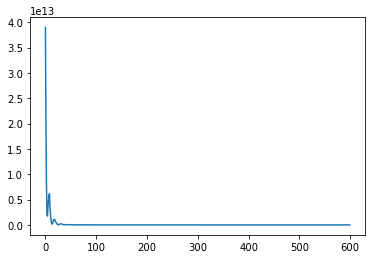

In [36]:
#plt.ylim([-10000,20000]) 
plt.plot(vae_model_d2_k1['train_losses_list'])

# из нормального распределения

generate_samples  torch.Size([10, 900]) torch.Size([10, 900])


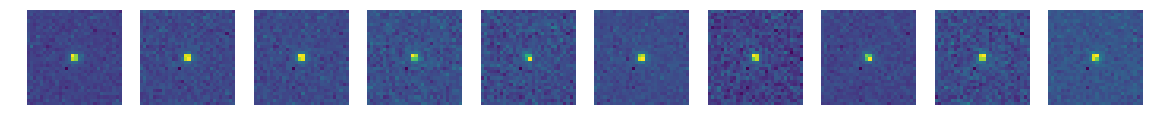

In [37]:
x = vae_model_d2_k1['model'].generate_samples(10)
show_images(x)

# из подложного

torch.Size([100, 5])
generate_samples1  torch.Size([100, 900]) torch.Size([100, 900])


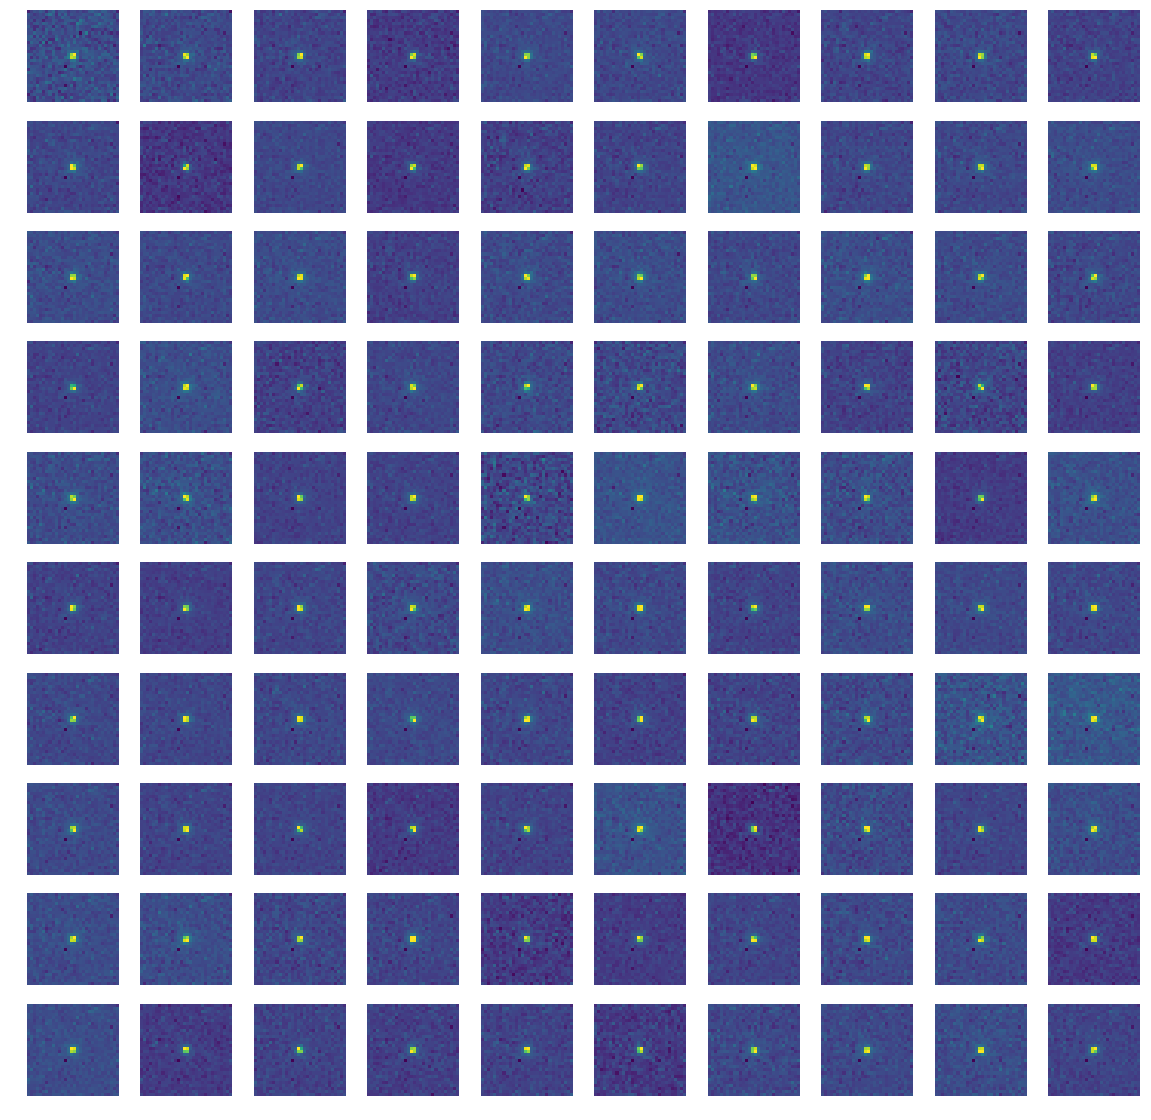

In [38]:
x = vae_model_d2_k1['model'].generate_samples1(10)
show_images(x)

In [122]:
predicted_stack = vae_model_d2_k1['model'].generate_samples(5000)
predicted_stack.shape

torch.Size([5000, 900])

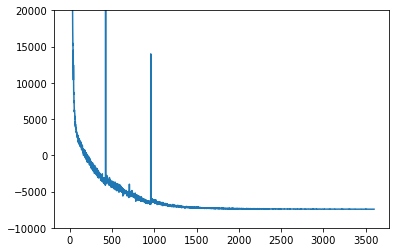

In [68]:
plt.ylim([-10000,20000]) 
plt.plot(vae_model_d2_k1_log['train_losses_list'])

### Визуализация латетного пространства (с точки зрения энкодера)